Same Unet3D model and ablations studies on MSD Dataset in this file

#### Imports

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.ndimage import generate_binary_structure, binary_erosion, distance_transform_edt


In [2]:
base_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus"
img_dir = os.path.join(base_dir, "imagesTr")
lbl_dir = os.path.join(base_dir, "labelsTr")

img_files = sorted(glob(os.path.join(img_dir, "*.nii*")))
lbl_files = sorted(glob(os.path.join(lbl_dir, "*.nii*")))

#### Reusable functions

In [3]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import torch
from skimage import measure
from scipy.ndimage import morphology

# Function to calculate OSR (Overlap-to-Signal Ratio)
# def overlap_signal_ratio(y_true, y_pred, smooth=1):
#     y_pred_labels = (y_pred >= 0.5).float()
#     intersection = torch.sum(y_true * y_pred_labels)
#     signal = torch.sum(y_true)
#     osr = (intersection + smooth) / (signal + smooth)
#     return osr

# Function to calculate USR (Under-Segmentation Rate)
def under_segmentation_rate(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_neg = torch.sum(y_true_labels * (1 - y_pred_labels))
    true_pos = torch.sum(y_true_labels * y_pred_labels)
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    usr = (false_neg + smooth) / (ground_truth_area + prediction_area + smooth)
    return usr

# Function to calculate ASD (Average Surface Distance)

import torch.nn.functional as F

def bce_loss(y_true, y_pred):
    # Ensure y_true and y_pred have the same shape
    return F.binary_cross_entropy(y_pred, y_true)

# Function to calculate ASD (Average Surface Distance)
def over_segmentation_ratio(y_true, y_pred, smooth=1e-5):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_positives = torch.sum((y_pred_labels == 1) & (y_true_labels == 0))
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    osr = (false_positives + smooth) / (ground_truth_area + prediction_area + smooth)
    return osr


import numpy as np
from scipy.ndimage import morphology

# def average_surface_distance(y_true, y_pred, spacing=None):
#     """
#     Computes the Average Surface Distance (ASD) between the predicted and true binary masks.
    
#     Parameters:
#     - y_true (torch.Tensor): Ground truth binary mask.
#     - y_pred (torch.Tensor): Predicted binary mask.
#     - spacing (tuple or list): Voxel spacing for each dimension (optional). This accounts for anisotropic voxel sizes.
    
#     Returns:
#     - float: Average Surface Distance (ASD) between the surfaces of the ground truth and predicted masks.
#     """
    
#     # Convert tensors to numpy arrays and ensure boolean type
#     y_true_np = y_true.detach().cpu().numpy().astype(np.bool_)
#     y_pred_np = y_pred.detach().cpu().numpy().astype(np.bool_)
    
#     # Define connectivity for finding surface voxels
#     conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
    
#     # Surface voxels: Logical XOR between the binary mask and its eroded version
#     true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
#     pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
    
#     # Check for empty surfaces (in case of no object in the segmentation)
#     if np.sum(true_surface) == 0 or np.sum(pred_surface) == 0:
#         return float('inf')
    
#     # Compute the Euclidean distance transform from the surface
#     true_distances = morphology.distance_transform_edt(~true_surface, sampling=spacing)
#     pred_distances = morphology.distance_transform_edt(~pred_surface, sampling=spacing)
    
#     # Measure distances from one surface to the other
#     dist_pred_to_true = np.mean(true_distances[pred_surface != 0])
#     dist_true_to_pred = np.mean(pred_distances[true_surface != 0])
    
#     # Calculate ASD as the mean of the two distances
#     asd = (dist_pred_to_true + dist_true_to_pred) / 2.0
    
#     return asd


# Function to calculate HD (Hausdorff Distance)
def hausdorff_distance(y_true, y_pred):
    y_true_labels = (y_true >= 0.5).cpu().numpy().astype(np.bool_)  # Use np.bool_ instead of np.bool
    y_pred_labels = (y_pred >= 0.5).cpu().numpy().astype(np.bool_)

    distances = []
    for slice_idx in range(y_true_labels.shape[0]):
        true_slice = y_true_labels[slice_idx, :, :]
        pred_slice = y_pred_labels[slice_idx, :, :]

        if np.sum(true_slice) == 0 or np.sum(pred_slice) == 0:
            continue

        true_surface_points = np.argwhere(true_slice)
        pred_surface_points = np.argwhere(pred_slice)

        hd_forward = directed_hausdorff(true_surface_points, pred_surface_points)[0]
        hd_backward = directed_hausdorff(pred_surface_points, true_surface_points)[0]

        distances.append(max(hd_forward, hd_backward))

    return np.mean(distances) if distances else float('inf')

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    true_pos = torch.sum(y_true * y_pred)
    false_neg = torch.sum(y_true * (1 - y_pred))
    false_pos = torch.sum((1 - y_true) * y_pred)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky

# Combined loss: Binary Cross-Entropy + Tversky Loss
def combined_loss(y_true, y_pred):
    bce = F.binary_cross_entropy(y_pred, y_true)
    tversky = tversky_loss(y_true, y_pred)
    return 0.9*bce + tversky

# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    dice = (2 * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred_labels) + smooth)
    return dice

# Function to calculate Jaccard index (IoU)
def jaccard_index(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    union = torch.sum(y_true) + torch.sum(y_pred_labels) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard

# Function to calculate mean IoU (mIoU)
def mean_iou(y_true, y_pred, smooth=1):
    return jaccard_index(y_true, y_pred, smooth)  # Same as Jaccard for binary

# Function to calculate F1 score
def f1_score(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    true_pos = torch.sum(y_true * y_pred_labels)
    precision = true_pos / (torch.sum(y_pred_labels) + smooth)
    recall = true_pos / (torch.sum(y_true) + smooth)
    f1 = (2 * precision * recall + smooth) / (precision + recall + smooth)
    return f1
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = (y_pred >= 0.5).float()  # Threshold for binary classification (0.5 for sigmoid output)
    correct = (y_pred_labels == y_true).float().sum()  # Count where predictions are correct
    return correct / y_true.numel()  # Return the percentage of correct predictions


#### Data demographics

In [4]:
img_files = sorted(glob(os.path.join(img_dir, "*.nii*")))
lbl_files = sorted(glob(os.path.join(lbl_dir, "*.nii*")))

print(f"Total Image-Label pairs: {len(img_files)}")


Total Image-Label pairs: 260


Unique image shapes: {(41, 47, 42), (35, 53, 36), (34, 45, 43), (34, 47, 40), (35, 54, 35), (36, 50, 33), (35, 51, 36), (32, 54, 34), (33, 47, 38), (35, 52, 37), (37, 57, 35), (37, 47, 34), (34, 50, 32), (38, 52, 35), (32, 53, 38), (38, 43, 41), (35, 53, 29), (35, 56, 34), (38, 53, 27), (36, 48, 38), (37, 45, 36), (36, 51, 34), (37, 56, 36), (38, 48, 40), (36, 40, 43), (33, 48, 38), (33, 49, 37), (37, 52, 32), (33, 53, 28), (36, 49, 36), (34, 53, 24), (35, 44, 44), (33, 50, 29), (35, 49, 40), (34, 50, 34), (37, 53, 33), (38, 48, 33), (36, 48, 40), (38, 50, 39), (33, 47, 42), (37, 52, 34), (38, 51, 31), (36, 47, 41), (36, 49, 38), (36, 52, 37), (35, 49, 33), (39, 45, 40), (35, 47, 45), (34, 53, 35), (34, 56, 31), (35, 53, 33), (36, 51, 29), (37, 43, 43), (37, 45, 40), (32, 52, 34), (33, 47, 35), (33, 49, 32), (38, 55, 31), (35, 52, 34), (37, 55, 26), (37, 50, 39), (35, 55, 33), (38, 55, 40), (36, 49, 31), (36, 54, 27), (34, 48, 32), (36, 49, 40), (34, 51, 37), (35, 46, 42), (35, 53, 35)

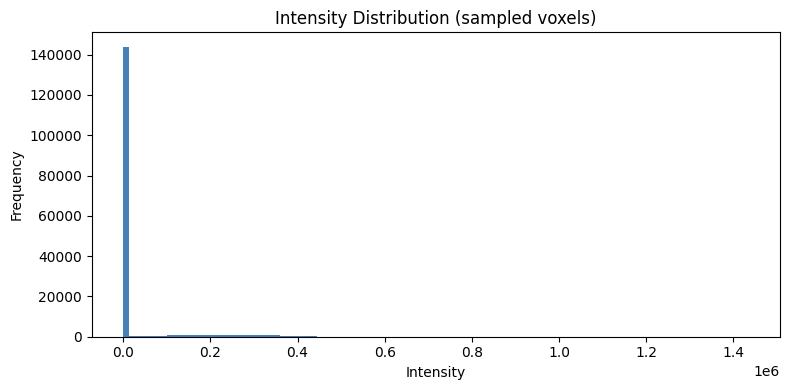

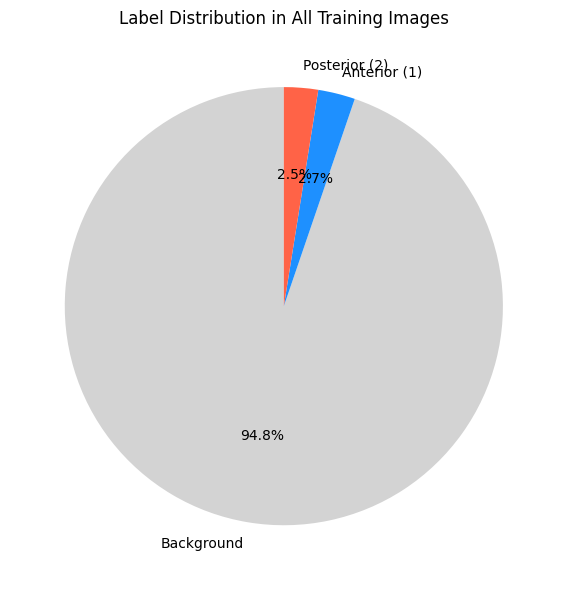

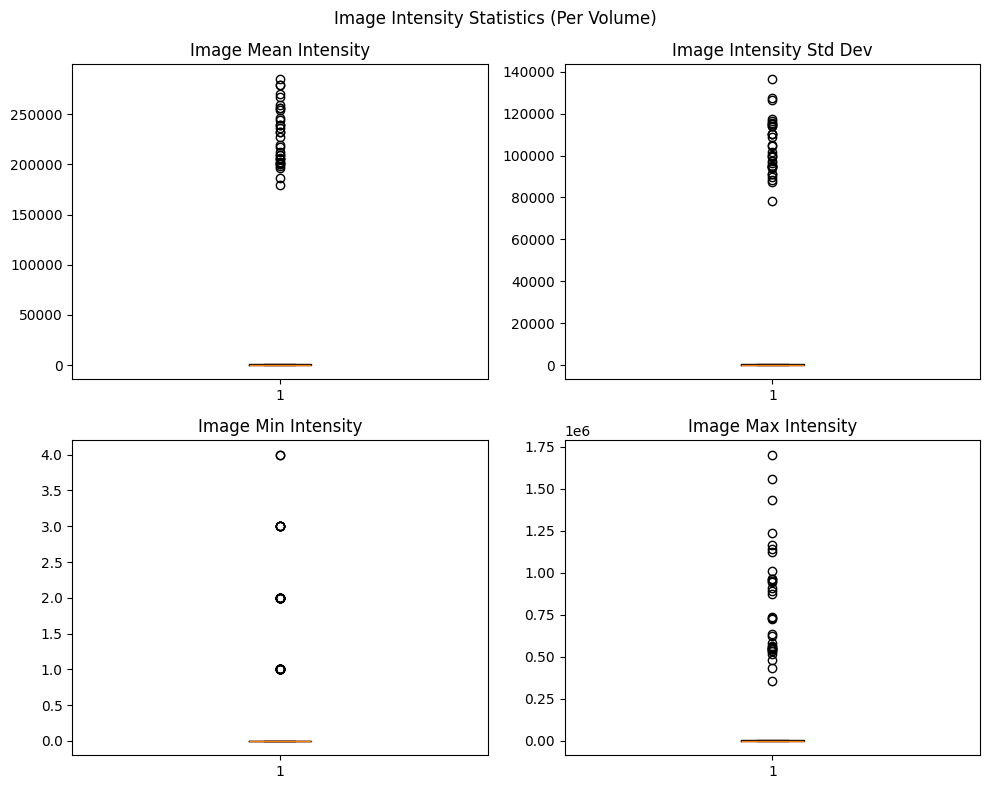

In [11]:

# --- Demographics Collection ---
all_shapes = []
all_intensities = []
label_counts = {0: 0, 1: 0, 2: 0}
img_means, img_stds, img_mins, img_maxs = [], [], [], []

# We'll sample intensities for histogram for performance
for img_fp, lbl_fp in zip(img_files, lbl_files):
    img = nib.load(img_fp).get_fdata()
    lbl = nib.load(lbl_fp).get_fdata()
    all_shapes.append(img.shape)
    # Intensity stats
    img_means.append(np.mean(img))
    img_stds.append(np.std(img))
    img_mins.append(np.min(img))
    img_maxs.append(np.max(img))
    all_intensities.extend(img.flatten()[::100])  # sample for histogram
    # Label stats
    for label in [0, 1, 2]:
        label_counts[label] += np.sum(lbl == label)

shapes_unique = set(all_shapes)
print("Unique image shapes:", shapes_unique)

# --- Summary Table ---
summary = {
    "Total Volumes": len(img_files),
    "Image Shape": list(shapes_unique)[0] if len(shapes_unique) == 1 else shapes_unique,
    "Intensity Mean (μ)": np.mean(img_means),
    "Intensity Std (σ)": np.mean(img_stds),
    "Intensity Min": np.min(img_mins),
    "Intensity Max": np.max(img_maxs),
    "Background Voxels (0)": label_counts[0],
    "Anterior Hippo Voxels (1)": label_counts[1],
    "Posterior Hippo Voxels (2)": label_counts[2],
    "Total Voxels": sum(label_counts.values()),
}
for label in [0, 1, 2]:
    summary[f"Label {label} %"] = 100 * label_counts[label] / summary["Total Voxels"]

print("\nSummary Table:")
for k, v in summary.items():
    print(f"{k}: {v}")

# --- Plots ---
plt.figure(figsize=(8,4))
plt.hist(all_intensities, bins=100, color='steelblue')
plt.title("Intensity Distribution (sampled voxels)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Label distribution pie
plt.figure(figsize=(6, 6))
labels = ['Background', 'Anterior (1)', 'Posterior (2)']
sizes = [label_counts[0], label_counts[1], label_counts[2]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgray', 'dodgerblue', 'tomato'])
plt.title('Label Distribution in All Training Images')
plt.tight_layout()
plt.show()

# Boxplots of per-image mean, std, min, max
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].boxplot(img_means)
ax[0, 0].set_title('Image Mean Intensity')
ax[0, 1].boxplot(img_stds)
ax[0, 1].set_title('Image Intensity Std Dev')
ax[1, 0].boxplot(img_mins)
ax[1, 0].set_title('Image Min Intensity')
ax[1, 1].boxplot(img_maxs)
ax[1, 1].set_title('Image Max Intensity')
plt.suptitle('Image Intensity Statistics (Per Volume)')
plt.tight_layout()
plt.show()




#### Padding Images and lables cause of imbalanced size

In [12]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob

# --- Paths ---
base_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus"
img_dir = os.path.join(base_dir, "imagesTr")
lbl_dir = os.path.join(base_dir, "labelsTr")
out_img_dir = os.path.join(base_dir, "Processed", "imagesTr")
out_lbl_dir = os.path.join(base_dir, "Processed", "labelsTr")
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_lbl_dir, exist_ok=True)

img_files = sorted(glob(os.path.join(img_dir, "*.nii*")))
lbl_files = sorted(glob(os.path.join(lbl_dir, "*.nii*")))

# --- Find max shape ---
shapes = []
for img_fp in img_files:
    img = nib.load(img_fp).get_fdata()
    shapes.append(img.shape)
max_shape = np.max(np.array(shapes), axis=0).astype(int)
print("Maximum shape for padding:", tuple(max_shape))

def pad_to_shape(img, target_shape):
    pad_width = []
    for d in range(3):
        total_pad = target_shape[d] - img.shape[d]
        pad_before = total_pad // 2
        pad_after = total_pad - pad_before
        pad_width.append((pad_before, pad_after))
    return np.pad(img, pad_width, mode='constant', constant_values=0)

# --- Padding and Saving ---
for img_fp, lbl_fp in zip(img_files, lbl_files):
    img_obj = nib.load(img_fp)
    img = img_obj.get_fdata()
    img_padded = pad_to_shape(img, max_shape)
    img_padded_nib = nib.Nifti1Image(img_padded, affine=img_obj.affine, header=img_obj.header)
    fname = os.path.basename(img_fp)
    nib.save(img_padded_nib, os.path.join(out_img_dir, fname))

    lbl_obj = nib.load(lbl_fp)
    lbl = lbl_obj.get_fdata()
    lbl_padded = pad_to_shape(lbl, max_shape)
    lbl_padded_nib = nib.Nifti1Image(lbl_padded, affine=lbl_obj.affine, header=lbl_obj.header)
    fname_lbl = os.path.basename(lbl_fp)
    nib.save(lbl_padded_nib, os.path.join(out_lbl_dir, fname_lbl))

print(f"Padded images and labels saved to {out_img_dir} and {out_lbl_dir}")


Maximum shape for padding: (43, 59, 47)
Padded images and labels saved to D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr and D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr


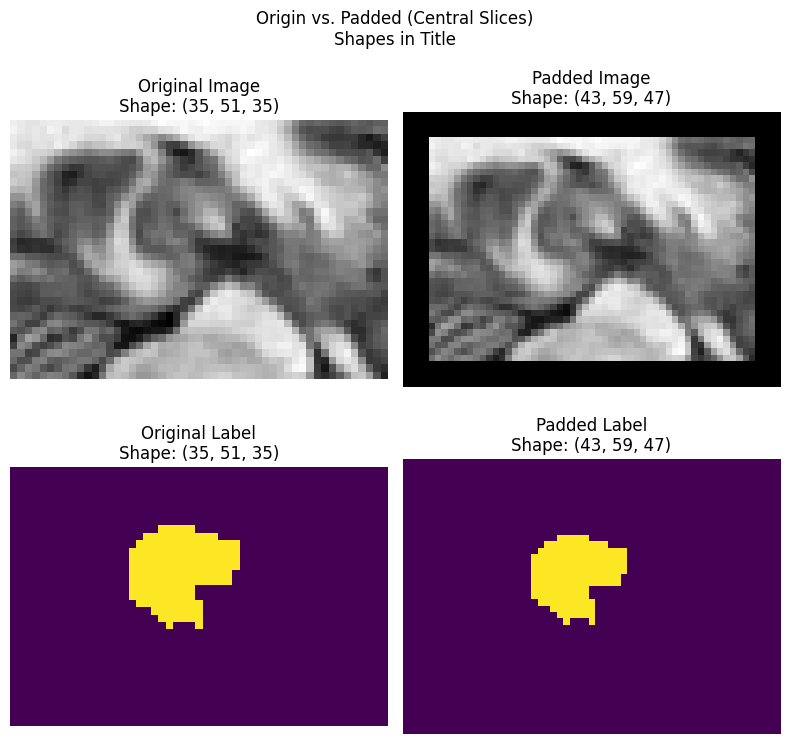

In [16]:

# --- Plot Example (Origin & Padded) ---
# Pick first file as example
example_idx = 0
img_fp = img_files[example_idx]
lbl_fp = lbl_files[example_idx]

img_obj = nib.load(img_fp)
lbl_obj = nib.load(lbl_fp)
img = img_obj.get_fdata()
lbl = lbl_obj.get_fdata()

img_padded = pad_to_shape(img, max_shape)
lbl_padded = pad_to_shape(lbl, max_shape)

slice_idx = img.shape[2] // 2  # central slice (z)
pad_slice_idx = img_padded.shape[2] // 2

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].imshow(img[:, :, slice_idx], cmap='gray')
axes[0, 0].set_title(f"Original Image\nShape: {img.shape}")
axes[0, 1].imshow(img_padded[:, :, pad_slice_idx], cmap='gray')
axes[0, 1].set_title(f"Padded Image\nShape: {img_padded.shape}")
axes[1, 0].imshow(lbl[:, :, slice_idx])
axes[1, 0].set_title(f"Original Label\nShape: {lbl.shape}")
axes[1, 1].imshow(lbl_padded[:, :, pad_slice_idx])
axes[1, 1].set_title(f"Padded Label\nShape: {lbl_padded.shape}")

for ax in axes.flatten():
    ax.axis('off')
plt.suptitle("Origin vs. Padded (Central Slices)\nShapes in Title")
plt.tight_layout()
plt.show()


#### Split data

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

img_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr'
lbl_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr'

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

# Prepare list of (subject, img_path, lbl_path)
records = []
for fname in img_files:
    records.append({
        'subject': fname.replace('.nii.gz','').replace('.nii',''),
        'img_path': os.path.join(img_dir, fname),
        'lbl_path': os.path.join(lbl_dir, fname),
    })
df = pd.DataFrame(records)

# Split
train, temp = train_test_split(df, test_size=0.30, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)
train['split'] = 'train'
val['split'] = 'val'
test['split'] = 'test'
df_split = pd.concat([train, val, test]).reset_index(drop=True)
df_split.to_csv('hippo_split.csv', index=False)
print(df_split['split'].value_counts())
print("Maximum shape for padding:", tuple(max_shape))


split
train    182
val       39
test      39
Name: count, dtype: int64


NameError: name 'max_shape' is not defined

In [6]:
import os
import nibabel as nib

img_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr'
lbl_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr'

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

img_set = set(img_files)
lbl_set = set(lbl_files)

print(f"Total images: {len(img_set)}")
print(f"Total labels: {len(lbl_set)}")
print(f"Matching names: {len(img_set & lbl_set)}")
print(f"Unmatched in images: {img_set - lbl_set}")
print(f"Unmatched in labels: {lbl_set - img_set}")

# Print shape for first 3 matching files
matching = sorted(img_set & lbl_set)
for fname in matching[:3]:
    img_path = os.path.join(img_dir, fname)
    lbl_path = os.path.join(lbl_dir, fname)
    img_data = nib.load(img_path).get_fdata()
    lbl_data = nib.load(lbl_path).get_fdata()
    print(f"\nFile: {fname}")
    print(f"  Image shape: {img_data.shape}")
    print(f"  Label shape: {lbl_data.shape}")


Total images: 260
Total labels: 260
Matching names: 260
Unmatched in images: set()
Unmatched in labels: set()

File: hippocampus_001.nii
  Image shape: (43, 59, 47)
  Label shape: (43, 59, 47)

File: hippocampus_003.nii
  Image shape: (43, 59, 47)
  Label shape: (43, 59, 47)

File: hippocampus_004.nii
  Image shape: (43, 59, 47)
  Label shape: (43, 59, 47)


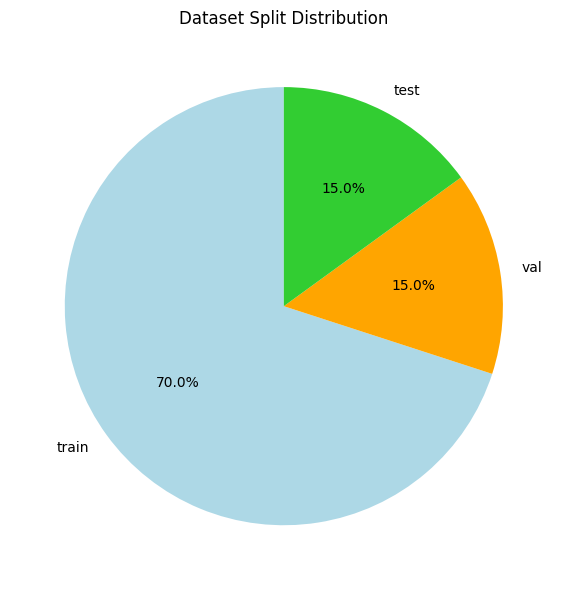

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('hippo_split.csv')
split_counts = df['split'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(split_counts, labels=split_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange', 'limegreen'])
plt.title('Dataset Split Distribution')
plt.tight_layout()
plt.show()


#### Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet3DDropoutResiduals(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, base_channels=32, dropout_rate=0.2):
        super(UNet3DDropoutResiduals, self).__init__()

        # Encoder layers with dropout and residual connections
        self.encoder_blocks = nn.ModuleList([
            self.conv_block(in_channels, base_channels, dropout_rate),  # Block 1
            self.conv_block(base_channels, base_channels * 2, dropout_rate),  # Block 2
            self.conv_block(base_channels * 2, base_channels * 4, dropout_rate),  # Block 3
            self.conv_block(base_channels * 4, base_channels * 8, dropout_rate),  # Block 4
            self.conv_block(base_channels * 8, base_channels * 16, dropout_rate)  # Block 5 (bottleneck)
        ])

        # Pooling layers
        self.pool = nn.MaxPool3d(kernel_size=2)

        # Decoder layers with ConvTranspose3d for upsampling
        self.decoder_blocks = nn.ModuleList([
            self.upconv_block(base_channels * 16, base_channels * 8),  # Decoder Block 1
            self.upconv_block(base_channels * 8, base_channels * 4),  # Decoder Block 2
            self.upconv_block(base_channels * 4, base_channels * 2),  # Decoder Block 3
            self.upconv_block(base_channels * 2, base_channels),  # Decoder Block 4
        ])

        # Convolutions after concatenation to reduce the number of channels with dropout and residual connections
        self.conv_after_concat = nn.ModuleList([
            self.conv_block(base_channels * 16, base_channels * 8, dropout_rate),  # After concat in Decoder Block 1
            self.conv_block(base_channels * 8, base_channels * 4, dropout_rate),   # After concat in Decoder Block 2
            self.conv_block(base_channels * 4, base_channels * 2, dropout_rate),   # After concat in Decoder Block 3
            self.conv_block(base_channels * 2, base_channels, dropout_rate),       # After concat in Decoder Block 4
        ])

        # Final output layer
        self.final_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate=0.1):
        # The convolutional block includes residual connections
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # Instance Normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate),  # Dropout layer
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # Instance Normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)  # Dropout layer
        )

    def forward_conv_block(self, x, block):
        # Apply the convolutional block and add residual connection
        out = block(x)
        if x.size() == out.size():
            out = out + x  # Residual connection: input added to output
        return out

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path with skip connections and residuals
        skip_connections = []
        for enc_block in self.encoder_blocks:
            x = self.forward_conv_block(x, enc_block)
            skip_connections.append(x)
            x = self.pool(x)
        x = skip_connections.pop()
        for i, dec_block in enumerate(self.decoder_blocks):
            skip = skip_connections.pop()

            # Upsample and concatenate with the skip connection
            x = dec_block(x)

            # Ensure the spatial dimensions match (padding if needed)
            x = self.pad_if_needed(x, skip)

            # Concatenate along the channel dimension
            x = torch.cat((x, skip), dim=1)

            # Pass through the convolution block (with residual connection) to reduce channels after concatenation
            x = self.forward_conv_block(x, self.conv_after_concat[i])

        # Final convolution to reduce to desired output channels
        x = self.final_conv(x)
        return x

    def pad_if_needed(self, x, skip):
        # Automatically pad the smaller tensor so it matches the spatial dimensions of the larger one
        diff_depth = skip.size(2) - x.size(2)
        diff_height = skip.size(3) - x.size(3)
        diff_width = skip.size(4) - x.size(4)

        x = F.pad(x, [diff_width // 2, diff_width - diff_width // 2,
                      diff_height // 2, diff_height - diff_height // 2,
                      diff_depth // 2, diff_depth - diff_depth // 2])
        return x

# Instantiate the model
modelUNet3DDropoutResiduals_V2 = UNet3DDropoutResiduals(in_channels=1, out_channels=1)
from torchsummary import summary
modelUNet3DDropoutResiduals_V2_MSD = modelUNet3DDropoutResiduals_V2.cuda()
summary(modelUNet3DDropoutResiduals_V2_MSD,
        input_size=(1, 43, 59, 47),
        device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 43, 59, 47]             896
    InstanceNorm3d-2       [-1, 32, 43, 59, 47]               0
              ReLU-3       [-1, 32, 43, 59, 47]               0
         Dropout3d-4       [-1, 32, 43, 59, 47]               0
            Conv3d-5       [-1, 32, 43, 59, 47]          27,680
    InstanceNorm3d-6       [-1, 32, 43, 59, 47]               0
              ReLU-7       [-1, 32, 43, 59, 47]               0
         Dropout3d-8       [-1, 32, 43, 59, 47]               0
         MaxPool3d-9       [-1, 32, 21, 29, 23]               0
           Conv3d-10       [-1, 64, 21, 29, 23]          55,360
   InstanceNorm3d-11       [-1, 64, 21, 29, 23]               0
             ReLU-12       [-1, 64, 21, 29, 23]               0
        Dropout3d-13       [-1, 64, 21, 29, 23]               0
           Conv3d-14       [-1, 64, 21,

## Ablations

#### RAW (padded + normalized) Training

In [72]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np

class NiftiPairDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, file_list):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.file_list = file_list  # List of base filenames (e.g., ["hippocampus_001.nii", ...])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        img_fp = os.path.join(self.img_dir, fname)
        lbl_fp = os.path.join(self.lbl_dir, fname)
        img = nib.load(img_fp).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_fp).get_fdata().astype(np.float32)
        # Normalize image (optional: here just scale to [0,1] if needed)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        # Add channel dimension for PyTorch [C, D, H, W]
        img = torch.from_numpy(img).unsqueeze(0)  # (1, 43, 59, 47)
        lbl = torch.from_numpy(lbl).unsqueeze(0)  # (1, 43, 59, 47)
        return img, lbl


In [70]:
from sklearn.model_selection import train_test_split

img_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr'
lbl_dir = r'D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr'

all_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
assert all_files == sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]), "Mismatch!"


# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
train_files, testval_files = train_test_split(all_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 182, Val: 39, Test: 39


In [73]:
batch_size = 2

train_dataset = NiftiPairDataset(img_dir, lbl_dir, train_files)
val_dataset   = NiftiPairDataset(img_dir, lbl_dir, val_files)
test_dataset  = NiftiPairDataset(img_dir, lbl_dir, test_files)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [74]:
# loaders
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class HippocampusSegmentationDataset(Dataset):
    def __init__(self, df):
        """
        df: pandas DataFrame with columns 'img_path', 'lbl_path'
        """
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        lbl_path = self.df.iloc[idx]['lbl_path']

        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_path).get_fdata().astype(np.float32)
        lbl_bin = ((lbl == 1) | (lbl == 2)).astype(np.float32)  # Only 0 or 1!

        img_tensor = torch.from_numpy(img).unsqueeze(0)    # [1, 43, 59, 47]
        lbl_tensor = torch.from_numpy(lbl_bin).unsqueeze(0)  # [1, 43, 59, 47]
        # Make sure dtype is float32!
        return img_tensor.float(), lbl_tensor.float()

# Create DataFrame with paths
def get_dataframe(img_dir, lbl_dir, split_csv=None):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    # Only include files that exist in both
    files = sorted(list(set(img_files) & set(lbl_files)))
    data = {'img_path': [os.path.join(img_dir, f) for f in files],
            'lbl_path': [os.path.join(lbl_dir, f) for f in files]}
    df = pd.DataFrame(data)
    if split_csv:
        split_info = pd.read_csv(split_csv)  # columns: filename, split (train/val/test)
        df['split'] = df['img_path'].apply(lambda x: os.path.basename(x)).map(split_info.set_index('filename')['split'])
    else:
        # Simple split: 70% train, 15% val, 15% test
        n = len(df)
        df['split'] = 'train'
        df.loc[int(n*0.7):int(n*0.85), 'split'] = 'val'
        df.loc[int(n*0.85):, 'split'] = 'test'
    return df

img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr"
lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

df = get_dataframe(img_dir, lbl_dir)
train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df   = df[df['split'] == 'val'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)

train_dataset = HippocampusSegmentationDataset(train_df)
val_dataset   = HippocampusSegmentationDataset(val_df)
test_dataset  = HippocampusSegmentationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


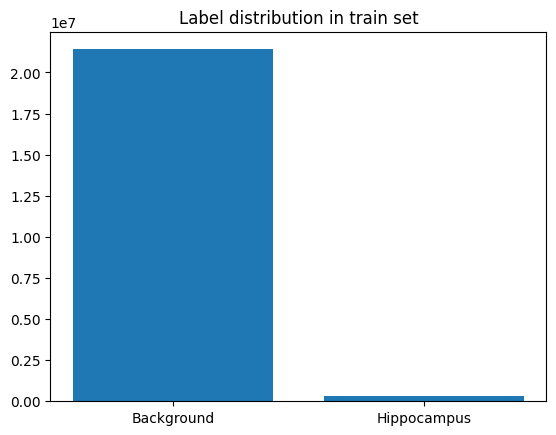

In [15]:
# Bar chart of binary label foreground/background
import matplotlib.pyplot as plt

all_vals = []
for _, lbl_tensor in train_dataset:
    arr = lbl_tensor.numpy().flatten()
    all_vals.append(arr)
all_vals = np.concatenate(all_vals)
bg = np.sum(all_vals == 0)
fg = np.sum(all_vals == 1)
plt.bar(['Background', 'Hippocampus'], [bg, fg])
plt.title('Label distribution in train set')
plt.show()


In [76]:
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

print(f"Training on device: {device}")
model_name = "MSD_NP_BINARY_UPDATED"
early_stopping_patience = 7
num_epochs = 250
epochs_no_improve = 0
best_val_loss = float('inf')

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_dice': [], 'val_dice': [],
    'train_jaccard': [], 'val_jaccard': [],
    'train_f1': [], 'val_f1': [],
    'train_iou': [], 'val_iou': [],
    'train_osr': [], 'val_osr': [],
    'train_usr': [], 'val_usr': [],
    'train_asd': [], 'val_asd': [],
    'train_hd': [], 'val_hd': []
}

print(f"Training on device: {device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = train_correct = train_dice = train_jaccard = train_f1 = train_iou = train_osr = train_usr = train_asd = train_hd = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = torch.sigmoid(outputs)
        loss = bce_loss(y_batch, outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    model.eval()
    val_loss = val_correct = val_dice = val_jaccard = val_f1 = val_iou = val_osr = val_usr = val_asd = val_hd = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch, outputs)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    train_loss /= n_train
    val_loss /= n_val
    train_acc = train_correct / n_train
    val_acc = val_correct / n_val
    train_dice /= n_train
    val_dice /= n_val
    train_jaccard /= n_train
    val_jaccard /= n_val
    train_f1 /= n_train
    val_f1 /= n_val
    train_iou /= n_train
    val_iou /= n_val
    train_osr /= n_train
    val_osr /= n_val
    train_usr /= n_train
    val_usr /= n_val
    train_asd /= n_train
    val_asd /= n_val
    train_hd /= n_train
    val_hd /= n_val

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, "
          f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
          f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, "
          f"Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, "
          f"Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}")

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break


history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")
### accidental run , but model is saved see results below

Training on device: cuda
Training on device: cuda
Epoch 1/250, Train Loss: 0.4214, Val Loss: 0.2709, Train Acc: 0.9367, Val Acc: 0.9928, Train Dice: 0.1621, Val Dice: 0.6836, Train Jaccard: 0.1053, Val Jaccard: 0.5208, Train F1: 0.8586, Val F1: 0.8161, Train IoU: 0.1053, Val IoU: 0.5208, Train OSR: 0.4450, Val OSR: 0.0881, Train USR: 0.3931, Val USR: 0.2286, Train ASD: 0.0000, Val ASD: 0.0000, Train HD: 28.4661, Val HD: 6.9707
Validation loss improved (inf -> 0.2709). Saving model...
Epoch 2/250, Train Loss: 0.2153, Val Loss: 0.1501, Train Acc: 0.9901, Val Acc: 0.9927, Train Dice: 0.5228, Val Dice: 0.7500, Train Jaccard: 0.3790, Val Jaccard: 0.6012, Train F1: 0.7666, Val F1: 0.8493, Train IoU: 0.3790, Val IoU: 0.6012, Train OSR: 0.1090, Val OSR: 0.1825, Train USR: 0.3685, Val USR: 0.0677, Train ASD: 0.0000, Val ASD: 0.0000, Train HD: inf, Val HD: 24.7250
Validation loss improved (0.2709 -> 0.1501). Saving model...
Epoch 3/250, Train Loss: 0.1304, Val Loss: 0.0928, Train Acc: 0.9928, Va

In [ ]:
### final metrics train, validation, testing etc
import os
import pickle
import torch
import pandas as pd


model_name = "MSD_NP_BINARY_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")


# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch, outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch, outputs).item() * bs
        test_dice    += dice_coefficient(y_batch, outputs).item() * bs
        test_jaccard += jaccard_index(y_batch, outputs).item() * bs
        test_f1      += f1_score(y_batch, outputs).item() * bs
        test_iou     += jaccard_index(y_batch, outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch, outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch, outputs).item() * bs
        test_hd      += hausdorff_distance(y_batch, outputs) * bs
# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda

=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0102 0.0105 0.0093
acc     0.9966 0.9959 0.9964
dice    0.8736 0.8467 0.8642
jaccard 0.7769 0.7350 0.7616
f1      0.9196 0.9035 0.9139
iou     0.7769 0.7350 0.7616
osr     0.0609 0.0876 0.0750
usr     0.0657 0.0659 0.0610
asd     0.0000 0.0000 0.0000
hd      3.1669 3.0939 3.1479


#### Preprocessing and saving

raw data-> padded +normalized -> preprocessed
raw data-> padded +normalized used for no preprocessing

In [36]:
import os
import nibabel as nib
import numpy as np
from skimage import exposure

# Directories
output_folder = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed"
images_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\padded"
output_dir = os.path.join(output_folder, "FP_PREPROCESSED")
os.makedirs(output_dir, exist_ok=True)

# Function to apply 3D CLAHE on a NIfTI image
def apply_3d_clahe(image_data, clip_limit=0.03, mask_background=True):
    # Normalize to [0,1]
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized = (image_data - min_val) / (max_val - min_val + 1e-8)
    # Optionally mask background
    if mask_background:
        mask = normalized > 0
        normalized = normalized * mask
    # CLAHE
    clahe = exposure.equalize_adapthist(normalized, clip_limit=clip_limit)
    # Reapply mask
    if mask_background:
        clahe = clahe * mask
    return clahe

# Process and save each image
for fname in sorted(os.listdir(images_dir)):
    if fname.endswith(".nii") or fname.endswith(".nii.gz"):
        in_path = os.path.join(images_dir, fname)
        img = nib.load(in_path)
        data = img.get_fdata()
        
        # Apply CLAHE
        clahe_data = apply_3d_clahe(data, clip_limit=0.03, mask_background=True)
        
        # Save preprocessed image
        out_img = nib.Nifti1Image(clahe_data.astype(np.float32), img.affine, img.header)
        out_path = os.path.join(output_dir, fname)
        nib.save(out_img, out_path)
        print(f"Saved preprocessed image: {out_path}")

print("All images processed and saved to 3DCLAHE_PREPROCESSED.")


Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_001.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_003.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_004.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_006.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_007.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_008.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_011.nii
Saved preproc

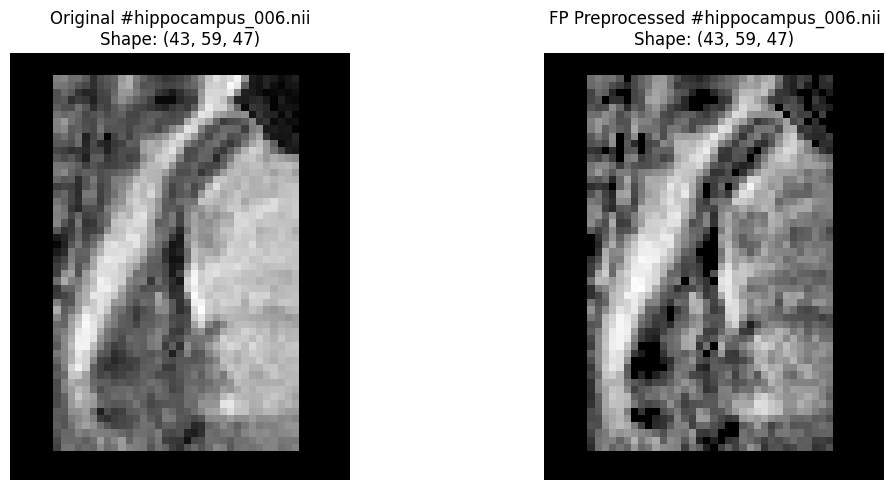

In [44]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

images_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr"
output_folder = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED"

img_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
prep_files = sorted([f for f in os.listdir(output_folder) if f.endswith('.nii') or f.endswith('.nii.gz')])

# print("imagesTr files:", img_files)
# print("Preprocessed files:", prep_files)

idx = 3  # third file
if len(img_files) <= idx or len(prep_files) <= idx:
    print(f"Not enough files for index {idx}. Using index 0 instead.")
    idx = 0

img_path = os.path.join(images_dir, img_files[idx])
prep_path = os.path.join(output_folder, prep_files[idx])

img = nib.load(img_path).get_fdata()
prep_img = nib.load(prep_path).get_fdata()

slice_idx = img.shape[0] // 2

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx, :, :], cmap='gray')
plt.title(f"Original #{img_files[idx]}\nShape: {img.shape}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(prep_img[slice_idx, :, :], cmap='gray')
plt.title(f"FP Preprocessed #{prep_files[idx]}\nShape: {prep_img.shape}")
plt.axis('off')

plt.tight_layout()
plt.show()


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_001.nii


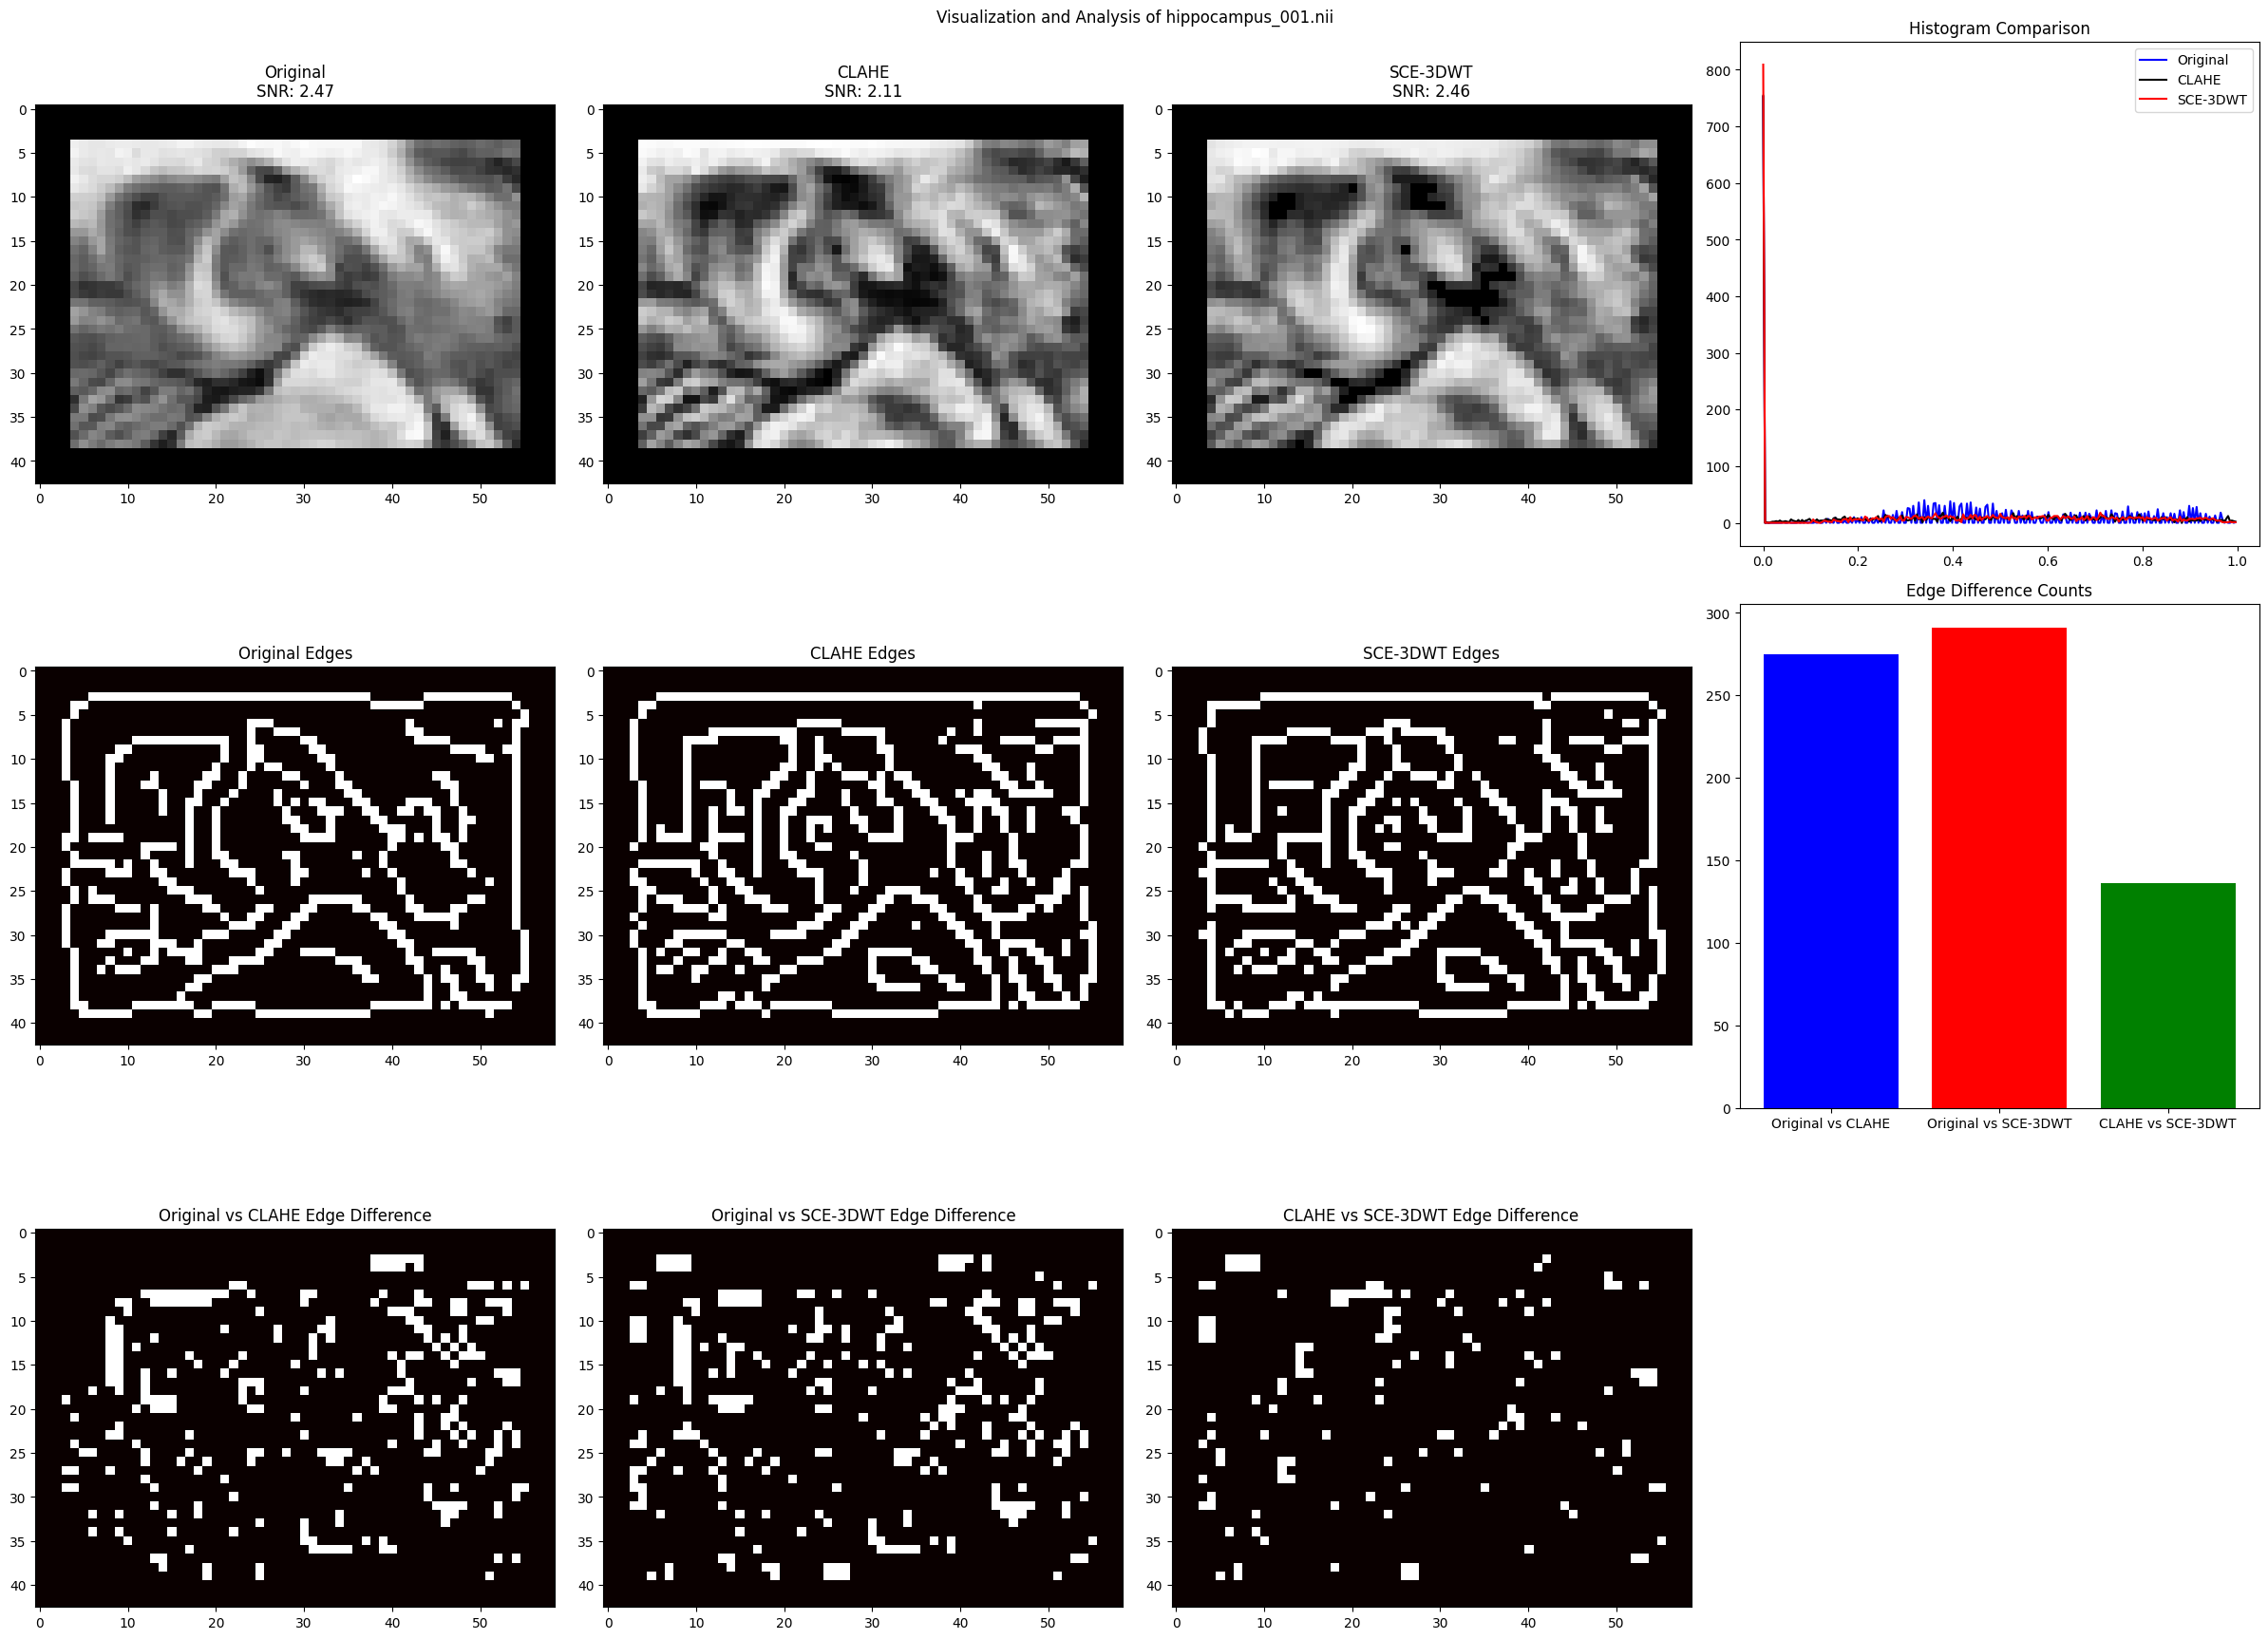

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_003.nii


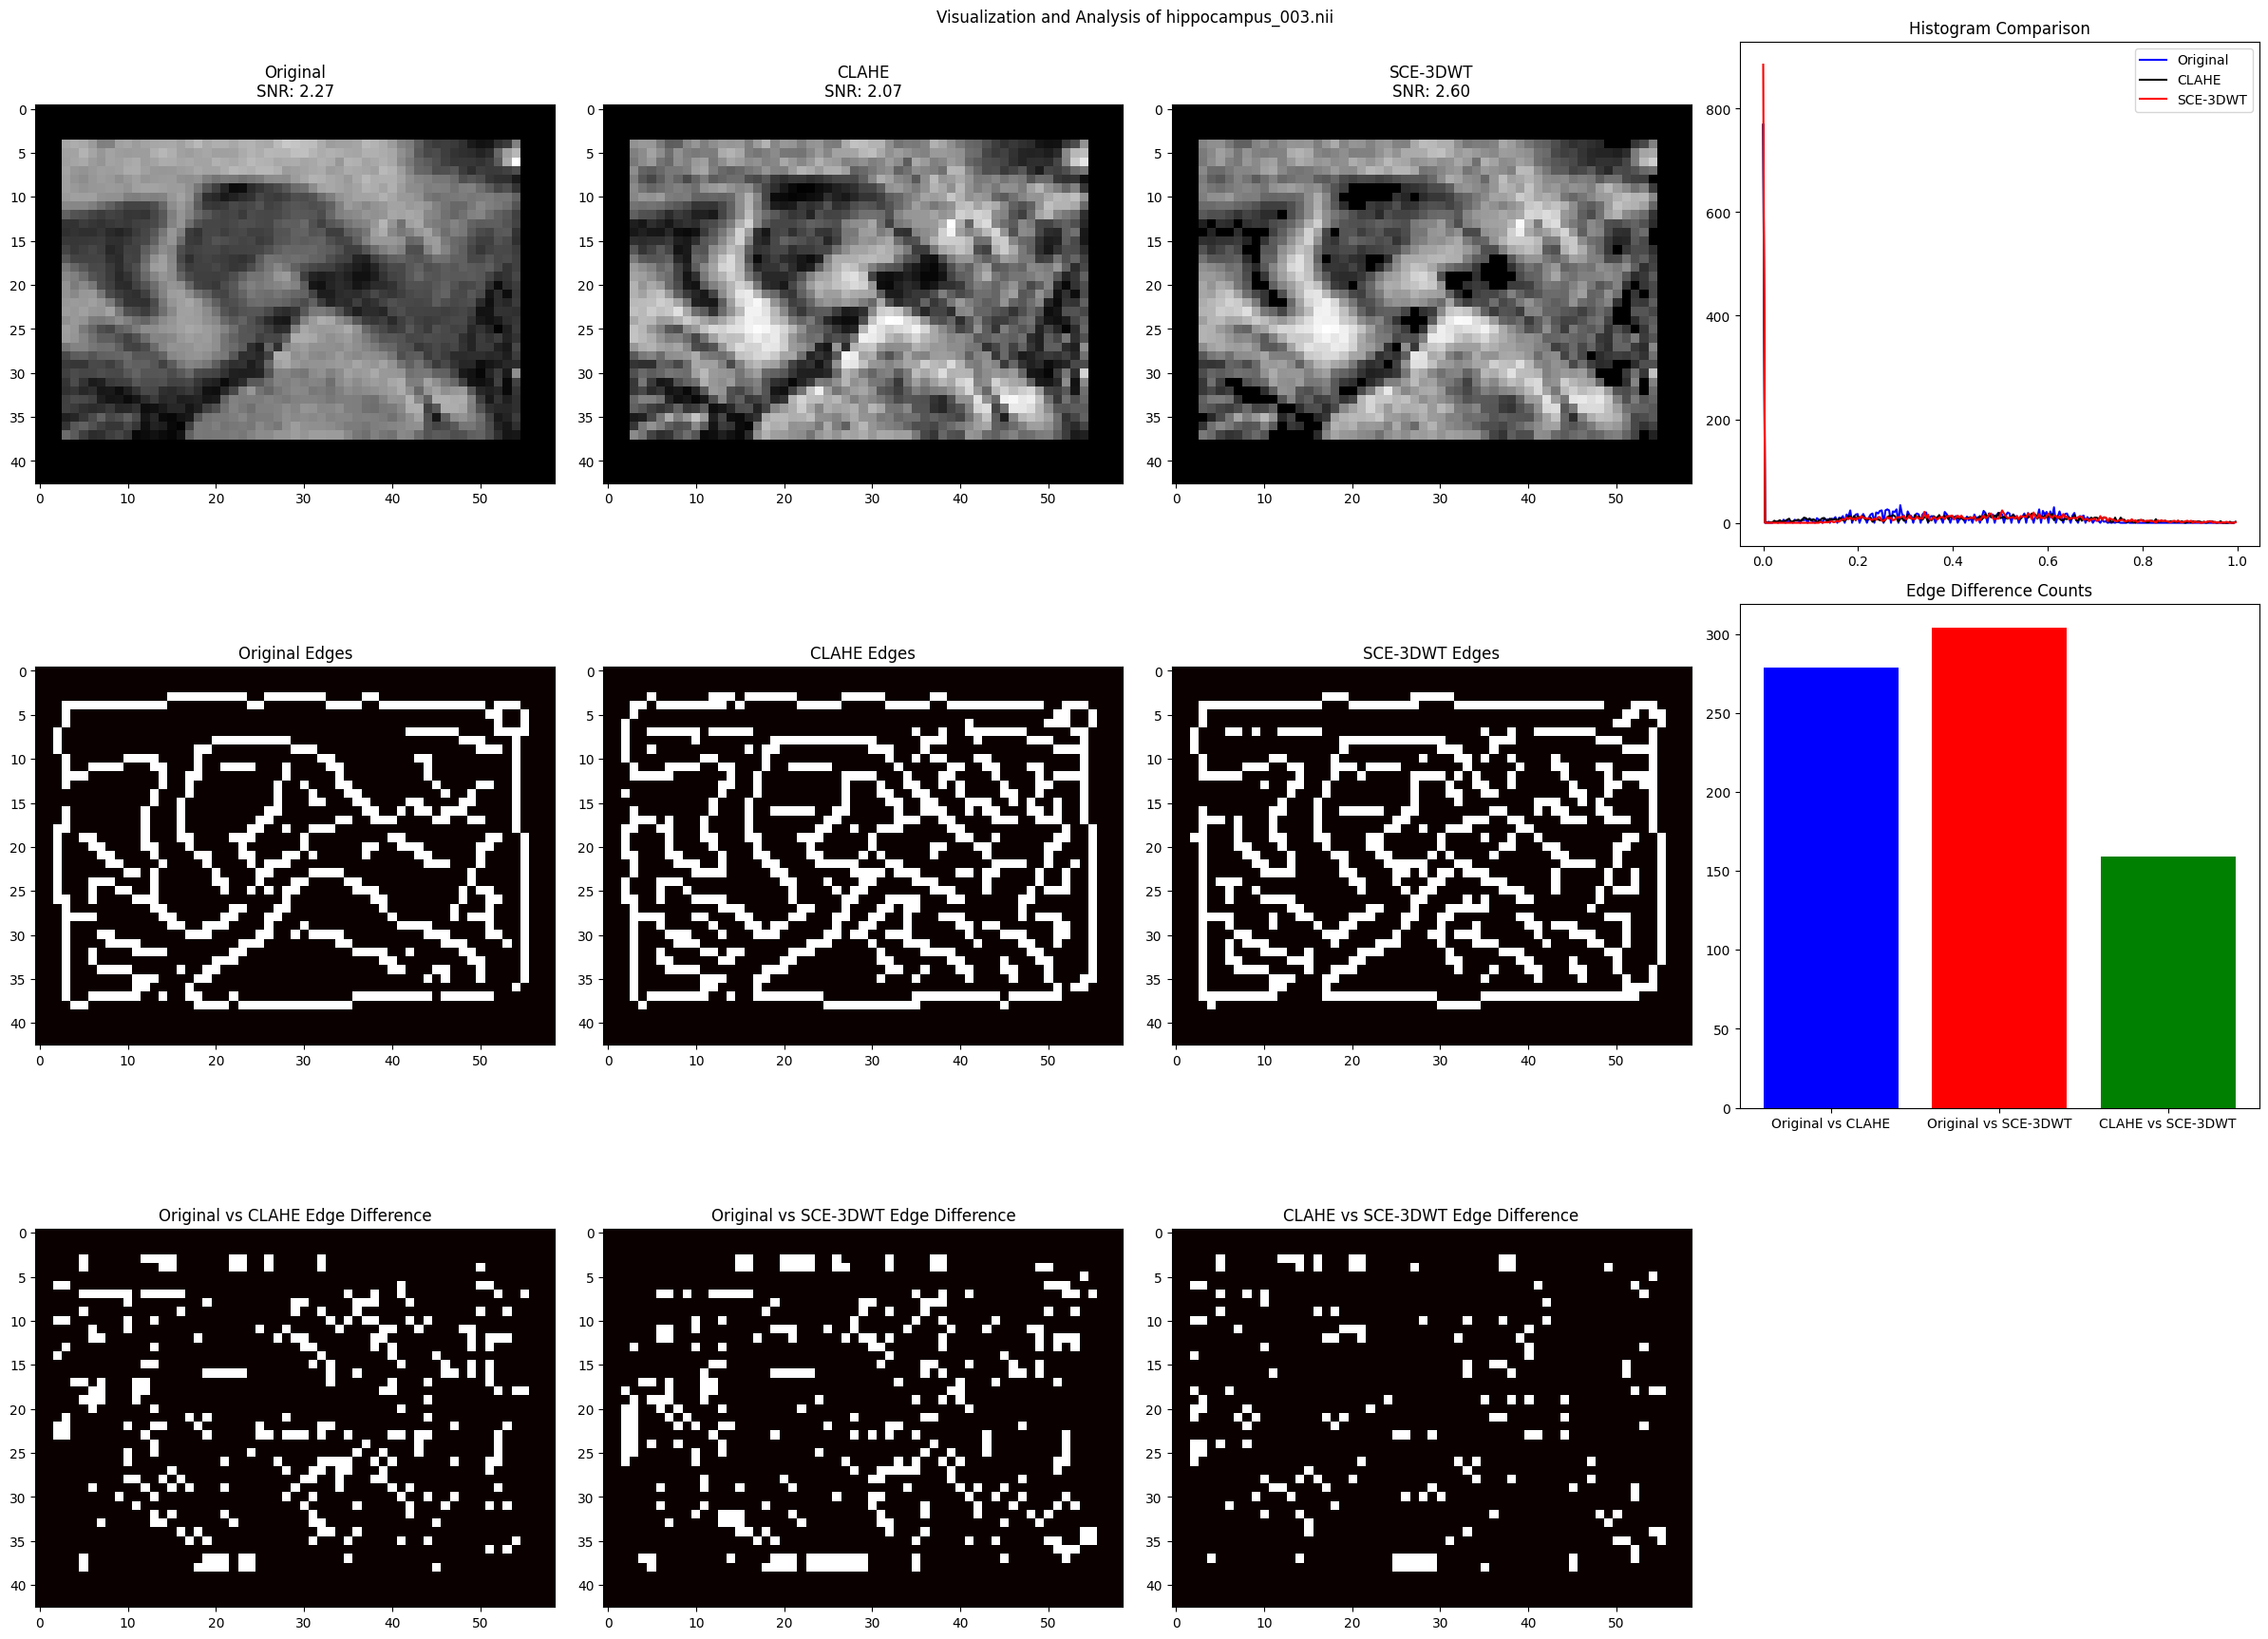

Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_004.nii


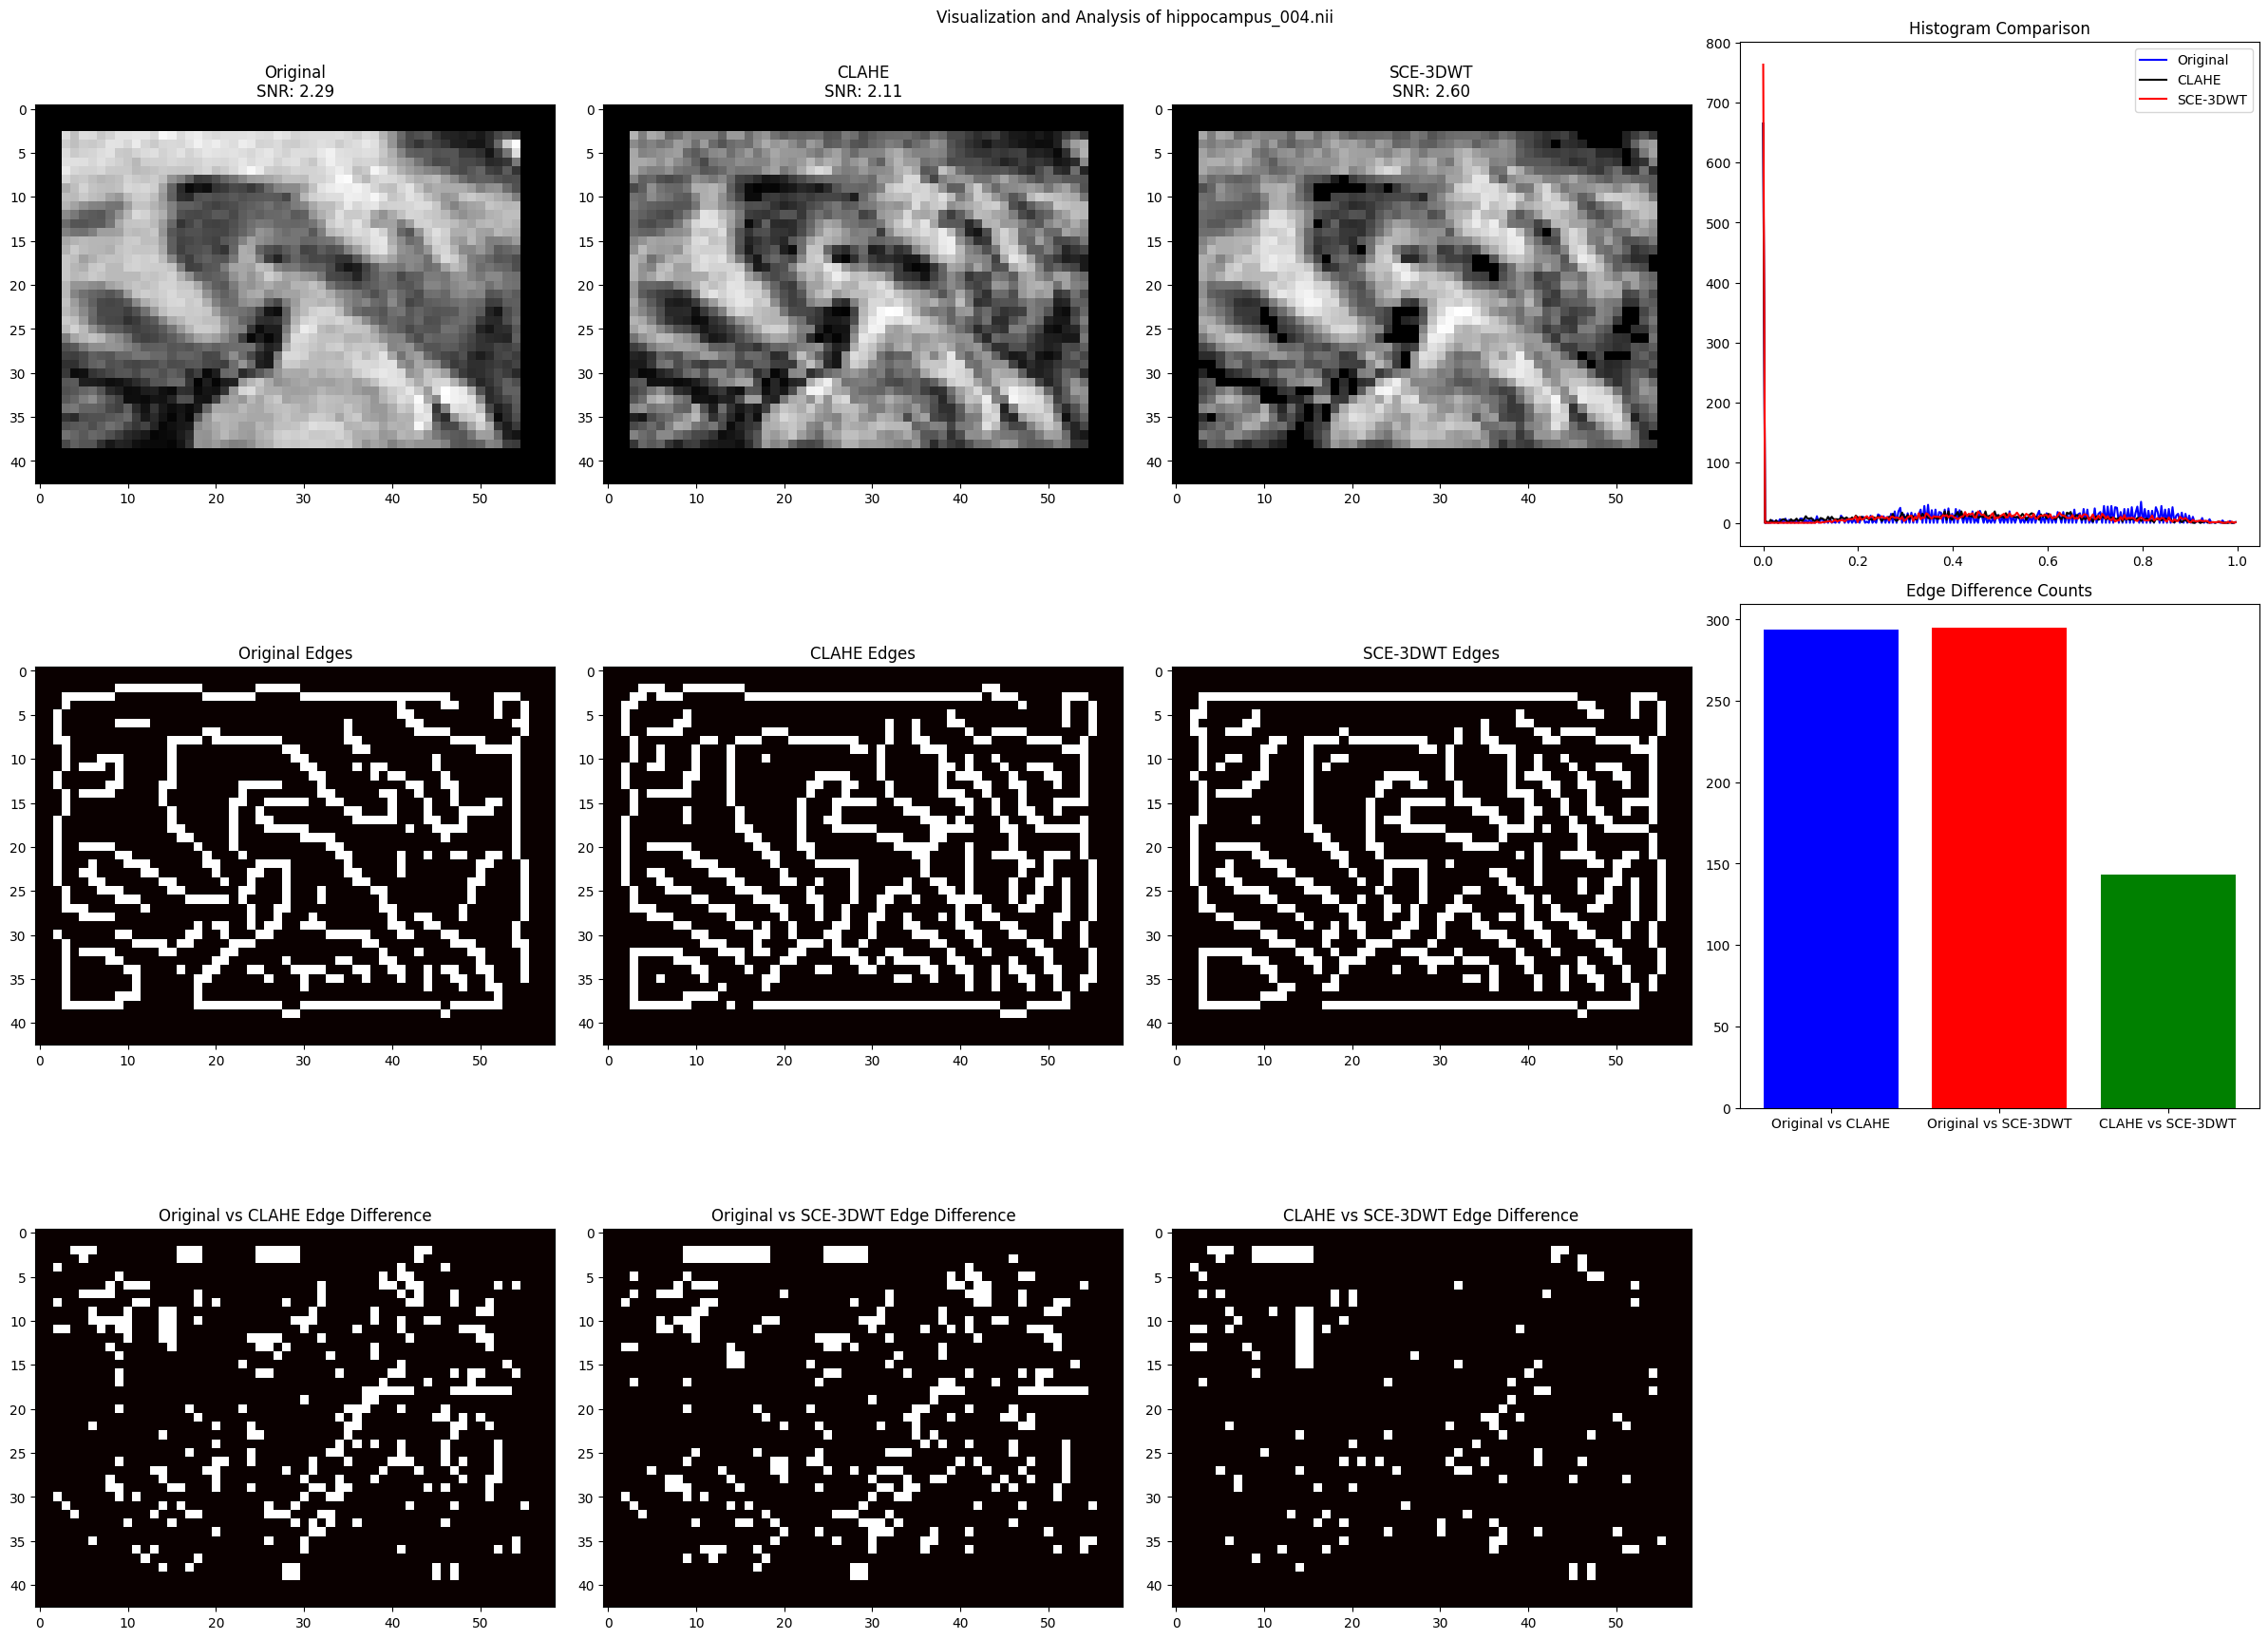

Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_006.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_007.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_008.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_011.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_014.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_015.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_017.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_034.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_035.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_036.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_037.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_038.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_039.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_040.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_041.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_042.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_067.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_068.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_070.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_074.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_075.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_077.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_083.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_084.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_087.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_088.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_089.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_090.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_091.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_092.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_093.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_094.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_095.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_109.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_114.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_123.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_124.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_125.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_126.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_127.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_130.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_132.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_133.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_135.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_136.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_138.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_141.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_142.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_143.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_144.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_145.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_146.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_148.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_149.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_150.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_152.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_154.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_155.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_156.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_157.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_158.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_160.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_161.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_162.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_163.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_164.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_165.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_166.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_169.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_170.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_171.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_172.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_173.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_174.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_175.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_176.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_177.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_178.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_180.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_181.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_184.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_185.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_188.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_189.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_190.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_193.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_199.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_203.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_204.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_205.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_207.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_210.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_212.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_219.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_220.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_221.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_222.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_223.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_224.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_225.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_226.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_227.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_228.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_229.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_243.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_244.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_245.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_248.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_249.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_250.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_251.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_252.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_253.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_257.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_259.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_260.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_261.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_263.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_264.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_265.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_268.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_269.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_274.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_276.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_277.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_279.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_280.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_286.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_287.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_288.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_289.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_290.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_292.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_294.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_310.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_311.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_314.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_316.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_317.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_318.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_319.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_320.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_321.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_322.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_325.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_326.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_327.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_328.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_329.nii
Saved processed image: D:\Faizaan\

d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_351.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_352.nii


d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\ai_new_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_353.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_354.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_355.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_356.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_358.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_359.nii
Saved processed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED\hippocampus_360.nii
Saved processed image: D:\Faizaan\

In [42]:
# edges difference plotting, and saving FP results
import os
import nibabel as nib
import numpy as np
from skimage import exposure, feature
import matplotlib.pyplot as plt
import pywt

# Directories
output_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr"
new_output_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED"
os.makedirs(new_output_dir, exist_ok=True)

def apply_3d_clahe(image_data, clip_limit=0.03, mask_background=True):
    normalized_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    if mask_background:
        mask = normalized_data > 0
        masked_data = normalized_data * mask
    else:
        masked_data = normalized_data
    clahe_data = exposure.equalize_adapthist(masked_data, clip_limit=clip_limit)
    if mask_background:
        clahe_data = clahe_data * mask
    return clahe_data

def apply_3d_fawt(image_data, wavelet='sym4', level=3, mode='symmetric', enhance=True, enhance_factor=1.5, background_threshold=0.1):
    image_data = image_data.copy()
    image_data[image_data < background_threshold] = 0
    coeffs = pywt.wavedecn(image_data, wavelet=wavelet, level=level, mode=mode)
    if enhance:
        for i in range(1, len(coeffs)):
            for key in coeffs[i].keys():
                if 'd' in key:
                    coeffs[i][key] *= enhance_factor
                else:
                    coeffs[i][key] *= (enhance_factor * 0.5)
    reconstructed_image = pywt.waverecn(coeffs, wavelet=wavelet, mode=mode)
    reconstructed_image[reconstructed_image < background_threshold] = 0
    return reconstructed_image

def pad_or_crop_to_shape(data, target_shape):
    # Crop if too large
    data = data[:target_shape[0], :target_shape[1], :target_shape[2]]
    # Pad if too small
    pad_width = [(0, max(0, t - s)) for s, t in zip(data.shape, target_shape)]
    data = np.pad(data, pad_width, mode='constant')
    return data

def compute_snr(image_data):
    signal = np.mean(image_data[image_data > 0])
    noise = np.std(image_data[image_data > 0])
    snr = signal / noise if noise != 0 else 0
    return snr

def visualize_results(original_data, clahe_data, fawt_data, file_name):
    # Visualize the middle slice
    slice_index = original_data.shape[2] // 2
    original_slice = original_data[:, :, slice_index]
    clahe_slice = clahe_data[:, :, slice_index]
    fawt_slice = fawt_data[:, :, slice_index]

    # Normalize for visualization
    original_slice_norm = (original_slice - np.min(original_slice)) / (np.max(original_slice) - np.min(original_slice) + 1e-8)
    clahe_slice_norm = (clahe_slice - np.min(clahe_slice)) / (np.max(clahe_slice) - np.min(clahe_slice) + 1e-8)
    fawt_slice_norm = (fawt_slice - np.min(fawt_slice)) / (np.max(fawt_slice) - np.min(fawt_slice) + 1e-8)

    # Edge detection
    original_edges = feature.canny(original_slice_norm).astype(np.float32)
    clahe_edges = feature.canny(clahe_slice_norm).astype(np.float32)
    fawt_edges = feature.canny(fawt_slice_norm).astype(np.float32)

    # --- Crop all edges to smallest shape ---
    min_shape = (
        min(original_edges.shape[0], clahe_edges.shape[0], fawt_edges.shape[0]),
        min(original_edges.shape[1], clahe_edges.shape[1], fawt_edges.shape[1])
    )
    original_edges = original_edges[:min_shape[0], :min_shape[1]]
    clahe_edges = clahe_edges[:min_shape[0], :min_shape[1]]
    fawt_edges = fawt_edges[:min_shape[0], :min_shape[1]]

    # Edge difference
    original_clahe_edge_diff = np.abs(original_edges - clahe_edges)
    original_fawt_edge_diff = np.abs(original_edges - fawt_edges)
    clahe_fawt_edge_diff = np.abs(clahe_edges - fawt_edges)

    # Normalize edge differences for colormap visualization
    if np.max(original_clahe_edge_diff) != 0:
        original_clahe_edge_diff /= np.max(original_clahe_edge_diff)
    if np.max(original_fawt_edge_diff) != 0:
        original_fawt_edge_diff /= np.max(original_fawt_edge_diff)
    if np.max(clahe_fawt_edge_diff) != 0:
        clahe_fawt_edge_diff /= np.max(clahe_fawt_edge_diff)

    # SNRs
    original_snr = compute_snr(original_slice)
    clahe_snr = compute_snr(clahe_slice)
    fawt_snr = compute_snr(fawt_slice)

    # Histograms
    original_hist, original_bins = np.histogram(original_slice_norm.flatten(), bins=256, range=[0, 1])
    clahe_hist, clahe_bins = np.histogram(clahe_slice_norm.flatten(), bins=256, range=[0, 1])
    fawt_hist, fawt_bins = np.histogram(fawt_slice_norm.flatten(), bins=256, range=[0, 1])

    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    fig.suptitle(f"Visualization and Analysis of {file_name}")

    axes[0, 0].imshow(original_slice_norm, cmap='gray')
    axes[0, 0].set_title(f'Original\nSNR: {original_snr:.2f}')
    axes[0, 1].imshow(clahe_slice_norm, cmap='gray')
    axes[0, 1].set_title(f'CLAHE\nSNR: {clahe_snr:.2f}')
    axes[0, 2].imshow(fawt_slice_norm, cmap='gray')
    axes[0, 2].set_title(f'SCE-3DWT\nSNR: {fawt_snr:.2f}')

    axes[0, 3].plot(original_bins[:-1], original_hist, color='blue', label='Original')
    axes[0, 3].plot(clahe_bins[:-1], clahe_hist, color='black', label='CLAHE')
    axes[0, 3].plot(fawt_bins[:-1], fawt_hist, color='red', label='SCE-3DWT')
    axes[0, 3].set_title('Histogram Comparison')
    axes[0, 3].legend()

    axes[1, 0].imshow(original_edges, cmap='hot')
    axes[1, 0].set_title('Original Edges')
    axes[1, 1].imshow(clahe_edges, cmap='hot')
    axes[1, 1].set_title('CLAHE Edges')
    axes[1, 2].imshow(fawt_edges, cmap='hot')
    axes[1, 2].set_title('SCE-3DWT Edges')
    axes[1, 3].bar(['Original vs CLAHE', 'Original vs SCE-3DWT', 'CLAHE vs SCE-3DWT'],
                   [np.sum(original_clahe_edge_diff), np.sum(original_fawt_edge_diff), np.sum(clahe_fawt_edge_diff)],
                   color=['blue', 'red', 'green'])
    axes[1, 3].set_title('Edge Difference Counts')

    axes[2, 0].imshow(original_clahe_edge_diff, cmap='hot')
    axes[2, 0].set_title('Original vs CLAHE Edge Difference')
    axes[2, 1].imshow(original_fawt_edge_diff, cmap='hot')
    axes[2, 1].set_title('Original vs SCE-3DWT Edge Difference')
    axes[2, 2].imshow(clahe_fawt_edge_diff, cmap='hot')
    axes[2, 2].set_title('CLAHE vs SCE-3DWT Edge Difference')
    axes[2, 3].remove()

    plt.tight_layout()
    plt.show()

# --- MAIN PROCESSING ---
count = 0
for file_name in os.listdir(output_dir):
    if file_name.endswith(".nii") or file_name.endswith(".nii.gz"):
        file_path = os.path.join(output_dir, file_name)
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()

        # Apply 3D CLAHE and FAWT
        clahe_data = apply_3d_clahe(img_data, clip_limit=0.03, mask_background=True)
        fawt_data = apply_3d_fawt(clahe_data, wavelet='coif5', level=2, mode='symmetric', enhance=True, enhance_factor=0.8)

        # Make sure fawt_data matches original shape before saving
        fawt_data = pad_or_crop_to_shape(fawt_data, img_data.shape)

        processed_img = nib.Nifti1Image(fawt_data, nii_img.affine, nii_img.header)
        output_file_path = os.path.join(new_output_dir, file_name)
        nib.save(processed_img, output_file_path)
        print(f"Saved processed image: {output_file_path}")

        # Visualize results for the first 3 images
        count += 1
        if count <= 3:
            visualize_results(img_data, clahe_data, fawt_data, file_name)

print("Processed and saved all images.")


#### FP Training

In [78]:
# loaders
# loaders
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class HippocampusSegmentationDataset(Dataset):
    def __init__(self, df):
        """
        df: pandas DataFrame with columns 'img_path', 'lbl_path'
        """
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        lbl_path = self.df.iloc[idx]['lbl_path']

        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_path).get_fdata().astype(np.float32)
        lbl_bin = ((lbl == 1) | (lbl == 2)).astype(np.float32)  # Only 0 or 1!

        img_tensor = torch.from_numpy(img).unsqueeze(0)    # [1, 43, 59, 47]
        lbl_tensor = torch.from_numpy(lbl_bin).unsqueeze(0)  # [1, 43, 59, 47]
        # Make sure dtype is float32!
        return img_tensor.float(), lbl_tensor.float()

# Create DataFrame with paths
def get_dataframe(img_dir, lbl_dir, split_csv=None):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    # Only include files that exist in both
    files = sorted(list(set(img_files) & set(lbl_files)))
    data = {'img_path': [os.path.join(img_dir, f) for f in files],
            'lbl_path': [os.path.join(lbl_dir, f) for f in files]}
    df = pd.DataFrame(data)
    if split_csv:
        split_info = pd.read_csv(split_csv)  # columns: filename, split (train/val/test)
        df['split'] = df['img_path'].apply(lambda x: os.path.basename(x)).map(split_info.set_index('filename')['split'])
    else:
        # Simple split: 70% train, 15% val, 15% test
        n = len(df)
        df['split'] = 'train'
        df.loc[int(n*0.7):int(n*0.85), 'split'] = 'val'
        df.loc[int(n*0.85):, 'split'] = 'test'
    return df

img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED"
lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

df = get_dataframe(img_dir, lbl_dir)

train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df   = df[df['split'] == 'val'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)
print("training:",len(train_df))
print("validation:",len(val_df))
print("testing:",len(test_df))
train_dataset = HippocampusSegmentationDataset(train_df)
val_dataset   = HippocampusSegmentationDataset(val_df)
test_dataset  = HippocampusSegmentationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


training: 182
validation: 39
testing: 39


In [79]:
# training
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

model_name = "MSD_FP_BINARY"
early_stopping_patience = 7
num_epochs = 250
epochs_no_improve = 0
best_val_loss = float('inf')

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_dice': [], 'val_dice': [],
    'train_jaccard': [], 'val_jaccard': [],
    'train_f1': [], 'val_f1': [],
    'train_iou': [], 'val_iou': [],
    'train_osr': [], 'val_osr': [],
    'train_usr': [], 'val_usr': [],
    'train_hd': [], 'val_hd': []
}

print(f"Training on device: {device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = train_correct = train_dice = train_jaccard = train_f1 = train_iou = train_osr = train_usr = train_asd = train_hd = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = torch.sigmoid(outputs)
        loss = bce_loss(y_batch, outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    model.eval()
    val_loss = val_correct = val_dice = val_jaccard = val_f1 = val_iou = val_osr = val_usr = val_asd = val_hd = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch, outputs)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    train_loss /= n_train
    val_loss /= n_val
    train_acc = train_correct / n_train
    val_acc = val_correct / n_val
    train_dice /= n_train
    val_dice /= n_val
    train_jaccard /= n_train
    val_jaccard /= n_val
    train_f1 /= n_train
    val_f1 /= n_val
    train_iou /= n_train
    val_iou /= n_val
    train_osr /= n_train
    val_osr /= n_val
    train_usr /= n_train
    val_usr /= n_val
    train_hd /= n_train
    val_hd /= n_val

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, "
          f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
          f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, "
          f"Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, "
          f"Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}")

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}.pth"))
        
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# Save training history
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")

Training on device: cuda
Epoch 1/250, Train Loss: 0.5419, Val Loss: 0.3834, Train Acc: 0.8269, Val Acc: 0.9921, Train Dice: 0.2782, Val Dice: 0.6961, Train Jaccard: 0.1766, Val Jaccard: 0.5357, Train F1: 0.6339, Val F1: 0.8236, Train IoU: 0.1766, Val IoU: 0.5357, Train OSR: 0.6871, Val OSR: 0.1543, Train USR: 0.0348, Val USR: 0.1498, Train HD: 31.4376, Val HD: 22.5706
Validation loss improved (inf -> 0.3834). Saving model...
Epoch 2/250, Train Loss: 0.3234, Val Loss: 0.2529, Train Acc: 0.9921, Val Acc: 0.9927, Train Dice: 0.7180, Val Dice: 0.7431, Train Jaccard: 0.5636, Val Jaccard: 0.5925, Train F1: 0.8347, Val F1: 0.8460, Train IoU: 0.5636, Val IoU: 0.5925, Train OSR: 0.1580, Val OSR: 0.1721, Train USR: 0.1241, Val USR: 0.0850, Train HD: 9.9083, Val HD: 5.8580
Validation loss improved (0.3834 -> 0.2529). Saving model...
Epoch 3/250, Train Loss: 0.2209, Val Loss: 0.1789, Train Acc: 0.9935, Val Acc: 0.9929, Train Dice: 0.7613, Val Dice: 0.7225, Train Jaccard: 0.6169, Val Jaccard: 0.566

In [53]:
### valdiation, testing graphs etc
import os
import pickle
import torch
import pandas as pd

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")

model_name = "MSD_FP_BINARY"
weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch, outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch, outputs).item() * bs
        test_dice    += dice_coefficient(y_batch, outputs).item() * bs
        test_jaccard += jaccard_index(y_batch, outputs).item() * bs
        test_f1      += f1_score(y_batch, outputs).item() * bs
        test_iou     += jaccard_index(y_batch, outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch, outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch, outputs).item() * bs
        test_hd      += hausdorff_distance(y_batch, outputs) * bs
# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda

=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0102 0.0111 0.0097
acc     0.9966 0.9958 0.9963
dice    0.8726 0.8401 0.8601
jaccard 0.7753 0.7252 0.7553
f1      0.9190 0.8997 0.9115
iou     0.7753 0.7252 0.7553
osr     0.0578 0.0870 0.0757
usr     0.0697 0.0731 0.0644
hd      3.2071 3.2136 3.2590


# Not presented experitments

#### CLAHE Training ( Not Presented)


In [54]:
import os
import nibabel as nib
import numpy as np
from skimage import exposure

# Directories
# img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED"
# lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

images_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\padded"
output_folder = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed"
output_dir = os.path.join(output_folder, "CLAHE")
os.makedirs(output_dir, exist_ok=True)

# Function to apply 3D CLAHE on a NIfTI image
def apply_3d_clahe(image_data, clip_limit=0.03, mask_background=True):
    # Normalize to [0,1]
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized = (image_data - min_val) / (max_val - min_val + 1e-8)
    # Optionally mask background
    if mask_background:
        mask = normalized > 0
        normalized = normalized * mask
    # CLAHE
    clahe = exposure.equalize_adapthist(normalized, clip_limit=clip_limit)
    # Reapply mask
    if mask_background:
        clahe = clahe * mask
    return clahe

# Process and save each image
for fname in sorted(os.listdir(images_dir)):
    if fname.endswith(".nii") or fname.endswith(".nii.gz"):
        in_path = os.path.join(images_dir, fname)
        img = nib.load(in_path)
        data = img.get_fdata()
        
        # Apply CLAHE
        clahe_data = apply_3d_clahe(data, clip_limit=0.03, mask_background=True)
        
        # Save preprocessed image
        out_img = nib.Nifti1Image(clahe_data.astype(np.float32), img.affine, img.header)
        out_path = os.path.join(output_dir, fname)
        nib.save(out_img, out_path)
        print(f"Saved preprocessed image: {out_path}")

print("All images processed and saved to 3DCLAHE_PREPROCESSED.")


Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_001.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_003.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_004.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_006.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_007.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_008.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE\hippocampus_011.nii
Saved preprocessed image: D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\P

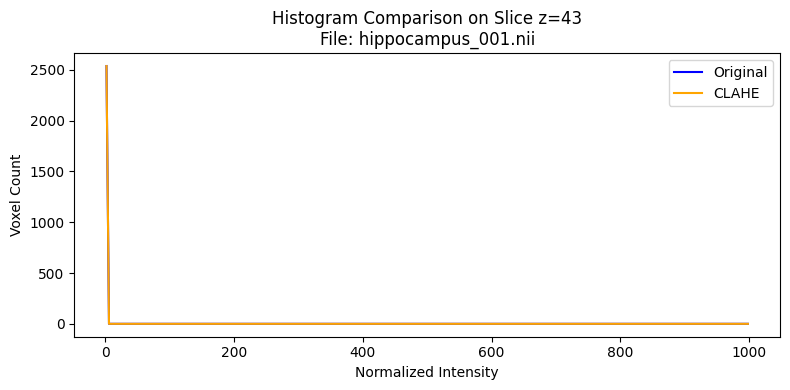

In [57]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Paths
# img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED"
# lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

# images_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\padded"
# output_folder = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed"
images_dir    = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\padded"
pre_dir       = os.path.join(r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed", "CLAHE")

# Find the first file
files = sorted([f for f in os.listdir(images_dir) if f.endswith((".nii",".nii.gz"))])
if not files:
    raise RuntimeError("No NIfTI files found in images_dir")
first_fname = files[0]

# Load original and CLAHE’d volumes
orig_img = nib.load(os.path.join(images_dir, first_fname)).get_fdata()
clahe_img = nib.load(os.path.join(pre_dir, first_fname)).get_fdata()

# Pick middle axial slice
slice_idx = orig_img.shape[2] // 2 +20
orig_slice  = orig_img[:, :, slice_idx]
clahe_slice = clahe_img[:, :, slice_idx]

# Normalize each slice to [0,1]
def normalize(x):
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-8)

orig_norm  = normalize(orig_slice)
clahe_norm = normalize(clahe_slice)

# Compute histograms
bins = 256
hist_o, bin_edges = np.histogram(orig_norm.flatten(),  bins=bins, range=(0,1000))
hist_c, _         = np.histogram(clahe_norm.flatten(), bins=bins, range=(0,1))
centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# Plot
plt.figure(figsize=(8,4))
plt.plot(centers, hist_o, label="Original", color="blue")
plt.plot(centers, hist_c, label="CLAHE",    color="orange")
plt.title(f"Histogram Comparison on Slice z={slice_idx}\nFile: {first_fname}")
plt.xlabel("Normalized Intensity")
plt.ylabel("Voxel Count")
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
# loaders
# loaders
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class HippocampusSegmentationDataset(Dataset):
    def __init__(self, df):
        """
        df: pandas DataFrame with columns 'img_path', 'lbl_path'
        """
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        lbl_path = self.df.iloc[idx]['lbl_path']

        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_path).get_fdata().astype(np.float32)
        lbl_bin = ((lbl == 1) | (lbl == 2)).astype(np.float32)  # Only 0 or 1!

        img_tensor = torch.from_numpy(img).unsqueeze(0)    # [1, 43, 59, 47]
        lbl_tensor = torch.from_numpy(lbl_bin).unsqueeze(0)  # [1, 43, 59, 47]
        # Make sure dtype is float32!
        return img_tensor.float(), lbl_tensor.float()

# Create DataFrame with paths
def get_dataframe(img_dir, lbl_dir, split_csv=None):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    # Only include files that exist in both
    files = sorted(list(set(img_files) & set(lbl_files)))
    data = {'img_path': [os.path.join(img_dir, f) for f in files],
            'lbl_path': [os.path.join(lbl_dir, f) for f in files]}
    df = pd.DataFrame(data)
    if split_csv:
        split_info = pd.read_csv(split_csv)  # columns: filename, split (train/val/test)
        df['split'] = df['img_path'].apply(lambda x: os.path.basename(x)).map(split_info.set_index('filename')['split'])
    else:
        # Simple split: 70% train, 15% val, 15% test
        n = len(df)
        df['split'] = 'train'
        df.loc[int(n*0.7):int(n*0.85), 'split'] = 'val'
        df.loc[int(n*0.85):, 'split'] = 'test'
    return df

img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\CLAHE"
lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

df = get_dataframe(img_dir, lbl_dir)

train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df   = df[df['split'] == 'val'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)
print("training:",len(train_df))
print("validation:",len(val_df))
print("testing:",len(test_df))
train_dataset = HippocampusSegmentationDataset(train_df)
val_dataset   = HippocampusSegmentationDataset(val_df)
test_dataset  = HippocampusSegmentationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")


training: 182
validation: 39
testing: 39
Training set shape: (182, 3)
Validation set shape: (39, 3)
Test set shape: (39, 3)


In [65]:
# training
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "models")
history_dir = os.path.join(os.getcwd(), "history")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

model_name = "MSD_CL_BINARY"
early_stopping_patience = 7
num_epochs = 250
epochs_no_improve = 0
best_val_loss = float('inf')

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_dice': [], 'val_dice': [],
    'train_jaccard': [], 'val_jaccard': [],
    'train_f1': [], 'val_f1': [],
    'train_iou': [], 'val_iou': [],
    'train_osr': [], 'val_osr': [],
    'train_usr': [], 'val_usr': [],
    'train_hd': [], 'val_hd': []
}

print(f"Training on device: {device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = train_correct = train_dice = train_jaccard = train_f1 = train_iou = train_osr = train_usr = train_asd = train_hd = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = torch.sigmoid(outputs)
        loss = bce_loss(y_batch, outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    model.eval()
    val_loss = val_correct = val_dice = val_jaccard = val_f1 = val_iou = val_osr = val_usr = val_asd = val_hd = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch, outputs)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    train_loss /= n_train
    val_loss /= n_val
    train_acc = train_correct / n_train
    val_acc = val_correct / n_val
    train_dice /= n_train
    val_dice /= n_val
    train_jaccard /= n_train
    val_jaccard /= n_val
    train_f1 /= n_train
    val_f1 /= n_val
    train_iou /= n_train
    val_iou /= n_val
    train_osr /= n_train
    val_osr /= n_val
    train_usr /= n_train
    val_usr /= n_val
    train_hd /= n_train
    val_hd /= n_val

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, "
          f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
          f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, "
          f"Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, "
          f"Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}")

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# Save training history
history_path = os.path.join(history_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")

Training on device: cuda
Epoch 1/250, Train Loss: 0.3554, Val Loss: 0.2256, Train Acc: 0.9518, Val Acc: 0.9896, Train Dice: 0.4197, Val Dice: 0.6028, Train Jaccard: 0.2846, Val Jaccard: 0.4361, Train F1: 0.7513, Val F1: 0.7867, Train IoU: 0.2846, Val IoU: 0.4361, Train OSR: 0.4004, Val OSR: 0.2079, Train USR: 0.1800, Val USR: 0.1895, Train HD: 17.2277, Val HD: 7.2558
Validation loss improved (inf -> 0.2256). Saving model...
Epoch 2/250, Train Loss: 0.1854, Val Loss: 0.1362, Train Acc: 0.9887, Val Acc: 0.9914, Train Dice: 0.5648, Val Dice: 0.6594, Train Jaccard: 0.3995, Val Jaccard: 0.4953, Train F1: 0.7739, Val F1: 0.8082, Train IoU: 0.3995, Val IoU: 0.4953, Train OSR: 0.1994, Val OSR: 0.1599, Train USR: 0.2360, Val USR: 0.1808, Train HD: 6.5484, Val HD: 6.9582
Validation loss improved (0.2256 -> 0.1362). Saving model...
Epoch 3/250, Train Loss: 0.1185, Val Loss: 0.0916, Train Acc: 0.9904, Val Acc: 0.9901, Train Dice: 0.6302, Val Dice: 0.6213, Train Jaccard: 0.4649, Val Jaccard: 0.4549

In [66]:
### valdiation, testing graphs etc
import os
import pickle
import torch
import pandas as pd

model_dir  = os.path.join(os.getcwd(), "models")
history_dir  = os.path.join(os.getcwd(), "history")
model_name = "MSD_CL_BINARY"
weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(history_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch, outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch, outputs).item() * bs
        test_dice    += dice_coefficient(y_batch, outputs).item() * bs
        test_jaccard += jaccard_index(y_batch, outputs).item() * bs
        test_f1      += f1_score(y_batch, outputs).item() * bs
        test_iou     += jaccard_index(y_batch, outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch, outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch, outputs).item() * bs
        test_hd      += hausdorff_distance(y_batch, outputs) * bs
# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda

=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0148 0.0149 0.0139
acc     0.9955 0.9948 0.9952
dice    0.8281 0.7987 0.8171
jaccard 0.7075 0.6663 0.6918
f1      0.8927 0.8763 0.8866
iou     0.7075 0.6663 0.6918
osr     0.0754 0.1030 0.0896
usr     0.0967 0.0985 0.0934
hd      3.2578 3.8835 3.4870


#### T Test

In [67]:
import matplotlib.pyplot as plt

def plot_3x2_overlays(img, gt, preds_dict, method_names, slice_idx, case_idx):
    """
    Plots overlays in a 3-row × 2-col grid:
    Row 1: Input | Ground Truth
    Row 2: NP | CL
    Row 3: SCE | FP
    """
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))
    # Row 1
    axs[0, 0].imshow(img[slice_idx], cmap='gray')
    axs[0, 0].set_title("Input MRI")
    axs[0, 0].axis('off')
    axs[0, 1].imshow(img[slice_idx], cmap='gray')
    axs[0, 1].imshow(gt[slice_idx], cmap='Greens', alpha=0.4)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis('off')
    # Row 2
    axs[1, 0].imshow(img[slice_idx], cmap='gray')
    axs[1, 0].imshow(preds_dict['NP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[1, 0].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[1, 0].set_title("Pred: NP")
    axs[1, 0].axis('off')
    axs[1, 1].imshow(img[slice_idx], cmap='gray')
    axs[1, 1].imshow(preds_dict['CL'][slice_idx], cmap='Reds', alpha=0.4)
    axs[1, 1].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[1, 1].set_title("Pred: CL")
    axs[1, 1].axis('off')
    # Row 3
    axs[2, 0].imshow(img[slice_idx], cmap='gray')
    axs[2, 0].imshow(preds_dict['SCE'][slice_idx], cmap='Reds', alpha=0.4)
    axs[2, 0].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[2, 0].set_title("Pred: SCE")
    axs[2, 0].axis('off')
    axs[2, 1].imshow(img[slice_idx], cmap='gray')
    axs[2, 1].imshow(preds_dict['FP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[2, 1].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[2, 1].set_title("Pred: FP")
    axs[2, 1].axis('off')
    plt.suptitle(f"Test Case #{case_idx} — Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


KeyError: 'SCE'

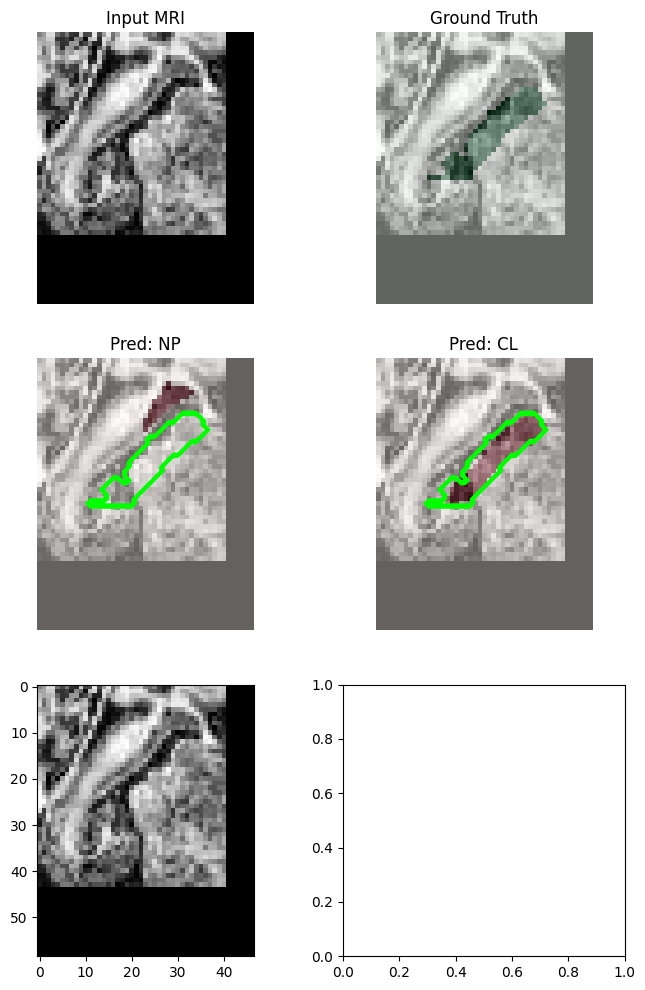

In [68]:
# Load your models as before
model_codes = ['NP', 'CL', 'FP']
model_names = [
    ("FP", "MSD_FP_BINARY"),
    ("NP", "MSD_NP_BINARY"),
    ("CL", "MSD_CL_BINARY")
]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from segmentation import UNet3DDropoutResiduals
models = {}
for code, model_short in model_names:
    model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(f"models/{model_short}.pth", map_location=device))
    model.eval()
    models[code] = model

# Choose the number of cases and slice index to visualize
n_cases = 3   # How many test cases to show
slice_idx = 32  # Or pick a central slice, e.g., img.shape[0]//2
global_case_idx = 0
for case_idx, (img_tensor, gt_tensor) in enumerate(test_loader):
    for b in range(img_tensor.shape[0]):
        img_b = img_tensor[b].cpu().numpy().squeeze()
        gt_b  = gt_tensor[b].cpu().numpy().squeeze()
        preds = {}
        for code in model_codes:
            with torch.no_grad():
                pred = torch.sigmoid(models[code](img_tensor[b:b+1].to(device))).cpu().numpy().squeeze()
                preds[code] = (pred >= 0.5).astype(np.float32)
        D = img_b.shape[0]
        slice_idx = D // 2
        plot_3x2_overlays(img_b, gt_b, preds, model_codes, slice_idx, global_case_idx)
        global_case_idx += 1
    if global_case_idx >= n_cases:
        break




## (Not presented) Transfer learning Harp to MSD
" domain shift not handled properly"

In [89]:
# loaders
# loaders
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class HippocampusSegmentationDataset(Dataset):
    def __init__(self, df):
        """
        df: pandas DataFrame with columns 'img_path', 'lbl_path'
        """
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        lbl_path = self.df.iloc[idx]['lbl_path']

        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_path).get_fdata().astype(np.float32)
        lbl_bin = ((lbl == 1) | (lbl == 2)).astype(np.float32)  # Only 0 or 1!

        img_tensor = torch.from_numpy(img).unsqueeze(0)    # [1, 43, 59, 47]
        lbl_tensor = torch.from_numpy(lbl_bin).unsqueeze(0)  # [1, 43, 59, 47]
        # Make sure dtype is float32!
        return img_tensor.float(), lbl_tensor.float()

# Create DataFrame with paths
def get_dataframe(img_dir, lbl_dir, split_csv=None):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    # Only include files that exist in both
    files = sorted(list(set(img_files) & set(lbl_files)))
    data = {'img_path': [os.path.join(img_dir, f) for f in files],
            'lbl_path': [os.path.join(lbl_dir, f) for f in files]}
    df = pd.DataFrame(data)
    if split_csv:
        split_info = pd.read_csv(split_csv)  # columns: filename, split (train/val/test)
        df['split'] = df['img_path'].apply(lambda x: os.path.basename(x)).map(split_info.set_index('filename')['split'])
    else:
        # Simple split: 70% train, 15% val, 15% test
        n = len(df)
        df['split'] = 'train'
        df.loc[int(n*0.7):int(n*0.85), 'split'] = 'val'
        df.loc[int(n*0.85):, 'split'] = 'test'
    return df

# MSD-NP: No preprocessing
img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr"
lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
df = get_dataframe(img_dir, lbl_dir)

train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df   = df[df['split'] == 'val'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)
print("training:",len(train_df))
print("validation:",len(val_df))
print("testing:",len(test_df))
train_dataset = HippocampusSegmentationDataset(train_df)
val_dataset   = HippocampusSegmentationDataset(val_df)
test_dataset  = HippocampusSegmentationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


training: 182
validation: 39
testing: 39


In [88]:
# # MSD-NP: No preprocessing
# img_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr"
# lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
# msd_df = get_dataframe(img_dir, lbl_dir)

# train_df = msd_df[msd_df['split'] == 'train'].reset_index(drop=True)
# val_df   = msd_df[msd_df['split'] == 'val'].reset_index(drop=True)
# test_df  = msd_df[msd_df['split'] == 'test'].reset_index(drop=True)

# train_dataset = HippocampusSegmentationDataset(train_df)
# val_dataset   = HippocampusSegmentationDataset(val_df)
# test_dataset  = HippocampusSegmentationDataset(test_df)

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
# val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
# test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


In [85]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
# harp_np_weights = "NewModels/UNet3D_NP_HARP_UPDATED.pth"
# model.load_state_dict(torch.load(harp_np_weights, map_location=device))
# print("Loaded HarP-NP weights.")


In [90]:
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# === Model, Optimizer, Scheduler ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir = os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

# --- Load HarP-NP pretrained weights ---
model.load_state_dict(torch.load("NewModels/UNet3D_NP_HARP_UPDATED.pth", map_location=device))
print("Loaded HarP-NP weights for fine-tuning.")
model_name = "Transfer_HARP_NP_to_MSD_NP"
early_stopping_patience = 7
num_epochs = 100
epochs_no_improve = 0
best_val_loss = float('inf')

# --- History logging ---
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_dice': [], 'val_dice': [],
    'train_jaccard': [], 'val_jaccard': [],
    'train_f1': [], 'val_f1': [],
    'train_iou': [], 'val_iou': [],
    'train_osr': [], 'val_osr': [],
    'train_usr': [], 'val_usr': [],
    'train_asd': [], 'val_asd': [],
    'train_hd': [], 'val_hd': []
}

print(f"Training on device: {device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = train_correct = train_dice = train_jaccard = train_f1 = train_iou = train_osr = train_usr = train_asd = train_hd = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = torch.sigmoid(outputs)
        loss = bce_loss(y_batch, outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
        train_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    model.eval()
    val_loss = val_correct = val_dice = val_jaccard = val_f1 = val_iou = val_osr = val_usr = val_asd = val_hd = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch, outputs)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += calculate_accuracy(y_batch, outputs).item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch, outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch, outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch, outputs).item() * X_batch.size(0)
            val_osr += over_segmentation_ratio(y_batch, outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch, outputs).item() * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch, outputs) * X_batch.size(0)

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    train_loss /= n_train
    val_loss /= n_val
    train_acc = train_correct / n_train
    val_acc = val_correct / n_val
    train_dice /= n_train
    val_dice /= n_val
    train_jaccard /= n_train
    val_jaccard /= n_val
    train_f1 /= n_train
    val_f1 /= n_val
    train_iou /= n_train
    val_iou /= n_val
    train_osr /= n_train
    val_osr /= n_val
    train_usr /= n_train
    val_usr /= n_val
    train_hd /= n_train
    val_hd /= n_val

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, "
          f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, "
          f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, "
          f"Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}")

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# --- Save history ---
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")

cuda
Loaded HarP-NP weights for fine-tuning.
Training on device: cuda
Epoch 1/100, Train Loss: 0.0966, Val Loss: 0.0915, Train Acc: 0.9742, Val Acc: 0.9735, Train Dice: 0.1287, Val Dice: 0.1565, Train Jaccard: 0.0717, Val Jaccard: 0.0882, Train F1: 0.8444, Val F1: 0.8186, Train IoU: 0.0717, Val IoU: 0.0882, Train OSR: 0.4765, Val OSR: 0.5089, Train USR: 0.3949, Val USR: 0.3347, Train HD: 42.0223, Val HD: 42.6544
Validation loss improved (inf -> 0.0915). Saving model...
Epoch 2/100, Train Loss: 0.0956, Val Loss: 0.0915, Train Acc: 0.9744, Val Acc: 0.9735, Train Dice: 0.1354, Val Dice: 0.1565, Train Jaccard: 0.0751, Val Jaccard: 0.0882, Train F1: 0.8357, Val F1: 0.8186, Train IoU: 0.0751, Val IoU: 0.0882, Train OSR: 0.4756, Val OSR: 0.5089, Train USR: 0.3891, Val USR: 0.3347, Train HD: 42.0223, Val HD: 42.6544
No improvement in validation loss for 1 epochs.
Epoch 3/100, Train Loss: 0.0959, Val Loss: 0.0915, Train Acc: 0.9743, Val Acc: 0.9735, Train Dice: 0.1372, Val Dice: 0.1565, Train J